# Data exploration and analysis: GooglePlayStoreApps

With a dataset with information from the applications in the Google Play Store, the aim is to obtain a model capable of predicting the rating for applications not yet rated by users.
Since the rating can be a real number between 1 and 5, this will be considered a regression problem.

There are two datasets:
- one with the data of the apps in the playstore, including information about the applications (such as category, rating and number of reviews, among others);
- another with the reviews made by users, including the text and the value of the sentiment/polarity identified in those comments.

To create the model, a series of tasks will first be carried out:
- explore the data and relationships between different features, identifying missing values and outliers;
- creation of a pipeline with the tasks to perform prior to model training;
- creation of various models, training and testing;
- use of metrics to select the final model.

# Tabla de contenidos

1. [Exploratory data analysis](#eda)
    1. [Application data](#dataapps)
    2. [Eliminate duplicate rows](#removeduplicates)
    3. [Dealing with missing values](#missingvalues)
    4. [Analysis of numerical features](#numericfeatures)
    5. [Analysis of categorical features](#categoricalfeatures) 
2. [Creation of the models](#modelcreation)
    1. [Dropping columns](#dropcolumns)
    2. [Separating datasets](#datasets)
    3. [Preprocessing](#preprocess)
    4. [Comparing results](#compareresults)

In [1]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading the files.

# -- Data about apps.
data_apps = pd.read_csv("data/googleplaystore.csv")

# -- Reviews made by users and sentiment analysis values.
data_reviews = pd.read_csv("data/googleplaystore_user_reviews.csv")

#### Regarding the reviews dataset

We are going to concentrate mainly on the data of the apps (data_apps) to try to predict the rating. While the data about reviews (the polarity of mixed sentiments in those reviews) might help us predict a Rating, for now we're going to use only app values to do so.

Especially since we only have data from 1074 apps, compared to the 8182 apps in the final dataset (removed duplicate rows and also apps without Rating) => reviews for less than 15% of the apps.

In [3]:
## Information about de reviews
data_reviews

App  \
0            10 Best Foods for You   
1            10 Best Foods for You   
2            10 Best Foods for You   
3            10 Best Foods for You   
4            10 Best Foods for You   
...                            ...   
64290  Houzz Interior Design Ideas   
64291  Houzz Interior Design Ideas   
64292  Houzz Interior Design Ideas   
64293  Houzz Interior Design Ideas   
64294  Houzz Interior Design Ideas   

                                       Translated_Review Sentiment  \
0      I like eat delicious food. That's I'm cooking ...  Positive   
1        This help eating healthy exercise regular basis  Positive   
2                                                    NaN       NaN   
3             Works great especially going grocery store  Positive   
4                                           Best idea us  Positive   
...                                                  ...       ...   
64290                                                NaN       NaN   
64291                                                NaN       NaN   
64292                                                NaN       NaN   
64293                                                NaN       NaN   
64294                                                NaN       NaN   

       Sentiment_Polarity  Sentiment_Subjectivity  
0                    1.00                0.533333  
1                    0.25                0.288462  
2                     NaN                     NaN  
3                    0.40                0.875000  
4                    1.00                0.300000  
...                   ...                     ...  
64290                 NaN                     NaN  
64291                 NaN                     NaN  
64292                 NaN                     NaN  
64293                 NaN                     NaN  
64294                 NaN                     NaN  

[64295 rows x 5 columns]

In [4]:
data_reviews.groupby("App").count()

Translated_Review  Sentiment  \
App                                                                            
10 Best Foods for You                                         194        194   
104 ÊâæÂ∑•‰Ωú - ÊâæÂ∑•‰Ωú ÊâæÊâìÂ∑• ÊâæÂÖºËÅ∑ Â±•Ê≠∑ÂÅ•Ê™¢ Â±•Ê≠∑Ë®∫ÁôÇÂÆ§                               40         40   
11st                                                           39         40   
1800 Contacts - Lens Store                                     80         80   
1LINE ‚Äì One Line with One Touch                                38         38   
...                                                           ...        ...   
Hotspot Shield Free VPN Proxy & Wi-Fi Security                 34         34   
Hotstar                                                        32         32   
Hotwire Hotel & Car Rental App                                 33         33   
Housing-Real Estate & Property                                 21         21   
Houzz Interior Design Ideas                                     0          0   

                                                Sentiment_Polarity  \
App                                                                  
10 Best Foods for You                                          194   
104 ÊâæÂ∑•‰Ωú - ÊâæÂ∑•‰Ωú ÊâæÊâìÂ∑• ÊâæÂÖºËÅ∑ Â±•Ê≠∑ÂÅ•Ê™¢ Â±•Ê≠∑Ë®∫ÁôÇÂÆ§                                40   
11st                                                            40   
1800 Contacts - Lens Store                                      80   
1LINE ‚Äì One Line with One Touch                                 38   
...                                                            ...   
Hotspot Shield Free VPN Proxy & Wi-Fi Security                  34   
Hotstar                                                         32   
Hotwire Hotel & Car Rental App                                  33   
Housing-Real Estate & Property                                  21   
Houzz Interior Design Ideas                                      0   

                                                Sentiment_Subjectivity  
App                                                                     
10 Best Foods for You                                              194  
104 ÊâæÂ∑•‰Ωú - ÊâæÂ∑•‰Ωú ÊâæÊâìÂ∑• ÊâæÂÖºËÅ∑ Â±•Ê≠∑ÂÅ•Ê™¢ Â±•Ê≠∑Ë®∫ÁôÇÂÆ§                                    40  
11st                                                                40  
1800 Contacts - Lens Store                                          80  
1LINE ‚Äì One Line with One Touch                                     38  
...                                                                ...  
Hotspot Shield Free VPN Proxy & Wi-Fi Security                      34  
Hotstar                                                             32  
Hotwire Hotel & Car Rental App                                      33  
Housing-Real Estate & Property                                      21  
Houzz Interior Design Ideas                                          0  

[1074 rows x 4 columns]

# Exploratory data analysis <a name="eda"></a>

Before creating the model, we will analyze the data. This involves looking at the values they can take, recategorizing the data if necessary, and looking at missing values and outliers and dealing with them in some way.

## Application data <a name="dataapps"></a>

In this dataset we have the following features:
- App: indicates the name of the application.
- Category: the category of the app (Art and design, Family, Sports, etc.).
- Rating (variable to predict): indicates the rating of the application, a real value (with a decimal) that can range from 1 to 5.
- Reviews: the number of reviews that the app has.
- Size: the size of the application.
- Installs: the number of installations of the apps.
- Type: if it is free or paid.
- Price: the price.
- Content Rating: the content rating (suitable for everyone, over 18, etc).
- Genres: the genres of the application.
- Last Updated: when it was last updated.
- Current Ver: the version of the application.
- Android Ver: the version of android in which it can be used.

In [5]:
data_apps

App             Category  \
0         Photo Editor & Candy Camera & Grid & ScrapBook       ART_AND_DESIGN   
1                                    Coloring book moana       ART_AND_DESIGN   
2      U Launcher Lite ‚Äì FREE Live Cool Themes, Hide ...       ART_AND_DESIGN   
3                                  Sketch - Draw & Paint       ART_AND_DESIGN   
4                  Pixel Draw - Number Art Coloring Book       ART_AND_DESIGN   
...                                                  ...                  ...   
10837                   Fr. Mike Schmitz Audio Teachings               FAMILY   
10838                             Parkinson Exercices FR              MEDICAL   
10839                      The SCP Foundation DB fr nn5n  BOOKS_AND_REFERENCE   
10840      iHoroscope - 2018 Daily Horoscope & Astrology            LIFESTYLE   
10841                               CLIENTE PERSONALSOFT               SPORTS   

       Rating  Reviews                Size     Installs  Type Price  \
0         4.1      159                 19M      10,000+  Free     0   
1         3.9      967                 14M     500,000+  Free     0   
2         4.7    87510                8.7M   5,000,000+  Free     0   
3         4.5   215644                 25M  50,000,000+  Free     0   
4         4.3      967                2.8M     100,000+  Free     0   
...       ...      ...                 ...          ...   ...   ...   
10837     5.0        4                3.6M         100+  Free     0   
10838     NaN        3                9.5M       1,000+  Free     0   
10839     4.5      114  Varies with device       1,000+  Free     0   
10840     4.5   398307                 19M  10,000,000+  Free     0   
10841     4.9     1230                 14M     500,000+  Free     0   

      Content Rating                     Genres Last Updated  \
0           Everyone               Art & Design   07/01/2018   
1           Everyone  Art & Design;Pretend Play   15/01/2018   
2           Everyone               Art & Design   01/08/2018   
3               Teen               Art & Design   08/06/2018   
4           Everyone    Art & Design;Creativity   20/06/2018   
...              ...                        ...          ...   
10837       Everyone                  Education   06/07/2018   
10838       Everyone                    Medical   20/01/2017   
10839     Mature 17+          Books & Reference   19/01/2015   
10840       Everyone                  Lifestyle   25/07/2018   
10841       Everyone                     Sports   09/03/2018   

              Current Ver         Android Ver  
0                   1.0.0        4.0.3 and up  
1                   2.0.0        4.0.3 and up  
2                   1.2.4        4.0.3 and up  
3      Varies with device          4.2 and up  
4                     1.1          4.4 and up  
...                   ...                 ...  
10837                   1          4.1 and up  
10838                   1          2.2 and up  
10839  Varies with device  Varies with device  
10840  Varies with device  Varies with device  
10841          2.0.833.18        4.0.3 and up  

[10842 rows x 13 columns]

Let's see the information about the type of the features.
We have 10842 rows. Most features are type Object. Rating is a float, and Reviews is an integer. Other features that could be numeric are:
- Size
- Installs
- Price

In [6]:
data_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10842 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9368 non-null   float64
 3   Reviews         10842 non-null  int64  
 4   Size            10842 non-null  object 
 5   Installs        10842 non-null  object 
 6   Type            10841 non-null  object 
 7   Price           10842 non-null  object 
 8   Content Rating  10842 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10842 non-null  object 
 11  Current Ver     10834 non-null  object 
 12  Android Ver     10840 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1.1+ MB


We can also see that we have some missing values in some columns. We will deal with these missing values later.

## Removing duplicate rows <a name="removeduplicates"></a>

Before we start dealing with missing values and looking at features, let's make sure we don't have duplicate rows for apps.

Number of duplicate rows: 1181

In [7]:
# Duplicated rows for app name => 1181
data_apps[data_apps.duplicated(['App'])]

App       Category  Rating  Reviews  \
229          Quick PDF Scanner + OCR FREE       BUSINESS     4.2    80805   
236                                   Box       BUSINESS     4.2   159872   
239                    Google My Business       BUSINESS     4.4    70991   
256                   ZOOM Cloud Meetings       BUSINESS     4.4    31614   
261             join.me - Simple Meetings       BUSINESS     4.0     6989   
...                                   ...            ...     ...      ...   
10715                  FarmersOnly Dating         DATING     3.0     1145   
10720  Firefox Focus: The privacy browser  COMMUNICATION     4.4    36981   
10730                         FP Notebook        MEDICAL     4.5      410   
10753      Slickdeals: Coupons & Shopping       SHOPPING     4.5    33599   
10768                                AAFP        MEDICAL     3.8       63   

                     Size     Installs  Type Price Content Rating  \
229    Varies with device   5,000,000+  Free     0       Everyone   
236    Varies with device  10,000,000+  Free     0       Everyone   
239    Varies with device   5,000,000+  Free     0       Everyone   
256                   37M  10,000,000+  Free     0       Everyone   
261    Varies with device   1,000,000+  Free     0       Everyone   
...                   ...          ...   ...   ...            ...   
10715                1.4M     100,000+  Free     0     Mature 17+   
10720                4.0M   1,000,000+  Free     0       Everyone   
10730                 60M      50,000+  Free     0       Everyone   
10753                 12M   1,000,000+  Free     0       Everyone   
10768                 24M      10,000+  Free     0       Everyone   

              Genres Last Updated         Current Ver         Android Ver  
229         Business   26/02/2018  Varies with device        4.0.3 and up  
236         Business   31/07/2018  Varies with device  Varies with device  
239         Business   24/07/2018    2.19.0.204537701          4.4 and up  
256         Business   20/07/2018      4.1.28165.0716          4.0 and up  
261         Business   16/07/2018           4.3.0.508          4.4 and up  
...              ...          ...                 ...                 ...  
10715         Dating   25/02/2016                 2.2          4.0 and up  
10720  Communication   06/07/2018                 5.2          5.0 and up  
10730        Medical   24/03/2018           2.1.0.372          4.4 and up  
10753       Shopping   30/07/2018                 3.9          4.4 and up  
10768        Medical   22/06/2018               2.3.1          5.0 and up  

[1181 rows x 13 columns]

Example with ROBLOX.
We can see that the number of reviews is the value that is changing => regarding that, we can keep the highest.
It also changes the category (!). Let's see if this happens for many apps.

In [8]:
data_apps[data_apps["App"] == "ROBLOX"].sort_values(by="Reviews", ascending=False)

App Category  Rating  Reviews Size      Installs  Type Price  \
2206  ROBLOX   FAMILY     4.5  4450890  67M  100,000,000+  Free     0   
2088  ROBLOX   FAMILY     4.5  4450855  67M  100,000,000+  Free     0   
1870  ROBLOX     GAME     4.5  4449910  67M  100,000,000+  Free     0   
2016  ROBLOX   FAMILY     4.5  4449910  67M  100,000,000+  Free     0   
1841  ROBLOX     GAME     4.5  4449882  67M  100,000,000+  Free     0   
1748  ROBLOX     GAME     4.5  4448791  67M  100,000,000+  Free     0   
1653  ROBLOX     GAME     4.5  4447388  67M  100,000,000+  Free     0   
1701  ROBLOX     GAME     4.5  4447346  67M  100,000,000+  Free     0   
4527  ROBLOX   FAMILY     4.5  4443407  67M  100,000,000+  Free     0   

     Content Rating                        Genres Last Updated   Current Ver  \
2206   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
2088   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
1870   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
2016   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
1841   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
1748   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
1653   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
1701   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   
4527   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   

     Android Ver  
2206  4.1 and up  
2088  4.1 and up  
1870  4.1 and up  
2016  4.1 and up  
1841  4.1 and up  
1748  4.1 and up  
1653  4.1 and up  
1701  4.1 and up  
4527  4.1 and up

How many apps have multiple categories? => 85.

Since there are just a few, in this case we are going to choose to keep the last category that was assigned to the app.
We are left with the most up-to-date entry regarding "Reviews".

In [9]:
temp = data_apps.groupby(["App"])["Category"].unique()
temp[temp.str.len() > 1]

App
8 Ball Pool                                                  [GAME, SPORTS]
A&E - Watch Full Episodes of TV Shows               [ENTERTAINMENT, FAMILY]
Angry Birds 2                                                [GAME, FAMILY]
Babbel ‚Äì Learn Languages                                [EDUCATION, FAMILY]
Barbie‚Ñ¢ Fashion Closet                                       [GAME, FAMILY]
                                                             ...           
Video Editor                                        [FAMILY, VIDEO_PLAYERS]
WWE                                                 [ENTERTAINMENT, FAMILY]
YouTube Gaming                                      [ENTERTAINMENT, FAMILY]
YouTube Kids                                        [ENTERTAINMENT, FAMILY]
busuu: Learn Languages - Spanish, English & More        [EDUCATION, FAMILY]
Name: Category, Length: 85, dtype: object

In [10]:
data_apps = data_apps.sort_values('Reviews', ascending=False).drop_duplicates('App').sort_index()

# Example
data_apps[data_apps["App"] == "ROBLOX"]

App Category  Rating  Reviews Size      Installs  Type Price  \
2206  ROBLOX   FAMILY     4.5  4450890  67M  100,000,000+  Free     0   

     Content Rating                        Genres Last Updated   Current Ver  \
2206   Everyone 10+  Adventure;Action & Adventure   31/07/2018  2.347.225742   

     Android Ver  
2206  4.1 and up

### Dealing with missing values <a name="missingvalues"></a>
 
We are now going to deal with the missing values in the features. We first calculate the sum of the missing values in each feature, ordered in descending order.

In [11]:
data_apps.isna().sum().sort_values(ascending=False)

Rating            1463
Current Ver          8
Android Ver          2
Category             1
Type                 1
Genres               1
App                  0
Reviews              0
Size                 0
Installs             0
Price                0
Content Rating       0
Last Updated         0
dtype: int64

We have quite a few missing values in Rating, which is the variable to predict, and a few others in Current Ver, Android Ver, Category, Type and Genres. Let's observe and try to solve these missing values.

Let's start with those that only have one missing value: Category, Type, and Genres.

In [12]:
# Let's see the row with missing value in Type
data_apps[data_apps["Type"].isna()]

App Category  Rating  Reviews                Size  \
9148  Command & Conquer: Rivals   FAMILY     NaN        0  Varies with device   

     Installs Type Price Content Rating    Genres Last Updated  \
9148        0  NaN     0   Everyone 10+  Strategy   28/06/2018   

             Current Ver         Android Ver  
9148  Varies with device  Varies with device

In [13]:
# What kind of values can Type have? ==> "Free" or "Paid".
data_apps["Type"].unique()

array(['Free', 'Paid', nan], dtype=object)

Since Type can only take the values "Free" or "Paid", and the price of that app is 0, we can fill in the missing value as "Free".

In [14]:
# Updating the value of the row 9148, column 6 (Type) por Free
data_apps.iloc[[9148],[6]] = "Free"

# data_apps[data_apps["Type"].isna()] # To check that we don't have that values

Now let's look at the row that has a missing value in Category.
Looking at the row, we can also see that it has a missing value for Genres.

A possible solution could be to delete this row. But first let's see what kind of categories and genres exist, to see if there is any category "Others" or something like that.

In [15]:
data_apps[data_apps["Category"].isna()]

App Category  Rating  Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      NaN     1.9       19   

       Size Installs  Type Price Content Rating Genres Last Updated  \
10472  3.0M   1,000+  Free     0       Everyone    NaN   11/02/2018   

      Current Ver Android Ver  
10472      1.0.19  4.0 and up

In [16]:
# Possible values for Category

data_apps["Category"].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', nan],
      dtype=object)

In [17]:
data_apps["Category"].value_counts()

FAMILY                 1876
GAME                    945
TOOLS                   829
BUSINESS                420
MEDICAL                 395
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  326
COMMUNICATION           315
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  170
VIDEO_PLAYERS           164
MAPS_AND_NAVIGATION     131
FOOD_AND_DRINK          112
EDUCATION               106
ENTERTAINMENT            87
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  79
HOUSE_AND_HOME           73
EVENTS                   64
ART_AND_DESIGN           61
PARENTING                60
COMICS                   56
BEAUTY                   53
Name: Category, dtype: int64

Let's look at the possible values for Genres. These seem to be overlapping quite a bit with the Category. You can see that all the values for Category appear as Genres. There are also new values for Genres that seem to indicate subcategories (for example, different types of games).

In [18]:
data_apps["Genres"].unique()

array(['Art & Design', 'Art & Design;Creativity', 'Auto & Vehicles',
       'Beauty', 'Books & Reference', 'Business', 'Comics',
       'Comics;Creativity', 'Communication', 'Dating', 'Education',
       'Education;Creativity', 'Education;Education',
       'Education;Pretend Play', 'Education;Brain Games', 'Entertainment',
       'Entertainment;Brain Games', 'Entertainment;Creativity',
       'Entertainment;Music & Video', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play', 'Card', 'Arcade', 'Puzzle',
       'Racing', 'Sports', 'Casual', 'Simulation', 'Adventure', 'Trivia',
       'Action', 'Word', 'Role Playing', 'Strategy', 'Board',
       'Simulation;Education', 'Action;Action & Adventure', 'Music',
       'Casual;Brain Games', 'Educational;Creativity',
       'Puzzle;Brain Games', 'Educational;Education',
       'Casual;Pretend Play', 'Educational;Brain Games',
       'Art & Design;Preten

There doesn't seem to be a category like "Other". Let's delete this row.

In [19]:
# Removing the row with missing value in Category and Genres
data_apps = data_apps.drop([10472])

Let's see the rows with missing values in Android View, and the possible values that feature can take.

In [20]:
data_apps[data_apps["Android Ver"].isna()]

App         Category  Rating  Reviews  Size Installs  \
4453  [substratum] Vacuum: P  PERSONALIZATION     4.4      230   11M   1,000+   
4490    Pi Dark [substratum]  PERSONALIZATION     4.5      189  2.1M  10,000+   

      Type   Price Content Rating           Genres Last Updated Current Ver  \
4453  Paid  $1.49        Everyone  Personalization   20/07/2018         4.4   
4490  Free       0       Everyone  Personalization   27/03/2018         1.1   

     Android Ver  
4453         NaN  
4490         NaN

In [21]:
data_apps["Android Ver"].unique()

array(['4.0.3 and up', '4.2 and up', '4.4 and up', '2.3 and up',
       '3.0 and up', '4.1 and up', '4.0 and up', '2.3.3 and up',
       'Varies with device', '2.2 and up', '5.0 and up', '6.0 and up',
       '1.6 and up', '1.5 and up', '2.1 and up', '7.0 and up',
       '5.1 and up', '4.3 and up', '4.0.3 - 7.1.1', '2.0 and up',
       '3.2 and up', '4.4W and up', '7.1 and up', '7.0 - 7.1.1',
       '8.0 and up', '5.0 - 8.0', '3.1 and up', '2.0.1 and up',
       '4.1 - 7.1.1', nan, '5.0 - 6.0', '1.0 and up', '2.2 - 7.1.1',
       '5.0 - 7.1.1'], dtype=object)

For simplicity, let's fill in the missing values with the value "Varies with device".

In [22]:
data_apps["Android Ver"] = data_apps["Android Ver"].fillna(value="Varies with device")

Let's look at the rows with missing values in Current Ver, and also the possible values for Current Ver. There is also a "Varies with device" value here. For simplicity, we also fill in these missing values with "Varies with device".

In [23]:
data_apps[data_apps["Current Ver"].isna()]

App             Category  Rating  Reviews  \
15     Learn To Draw Kawaii Characters       ART_AND_DESIGN     3.2       55   
1553              Market Update Helper   LIBRARIES_AND_DEMO     4.1    20145   
6322            Virtual DJ Sound Mixer                TOOLS     4.2     4010   
6803                         BT Master               FAMILY     NaN        0   
7333                       Dots puzzle               FAMILY     4.0      179   
7407                   Calculate My IQ               FAMILY     NaN       44   
7730                            UFO-CQ                TOOLS     NaN        1   
10342                   La Fe de Jesus  BOOKS_AND_REFERENCE     NaN        8   

       Size    Installs  Type   Price Content Rating             Genres  \
15     2.7M      5,000+  Free       0       Everyone       Art & Design   
1553    11k  1,000,000+  Free       0       Everyone   Libraries & Demo   
6322   8.7M    500,000+  Free       0       Everyone              Tools   
6803   222k        100+  Free       0       Everyone          Education   
7333    14M     50,000+  Paid  $0.99        Everyone             Puzzle   
7407   7.2M     10,000+  Free       0       Everyone      Entertainment   
7730   237k         10+  Paid  $0.99        Everyone              Tools   
10342  658k      1,000+  Free       0       Everyone  Books & Reference   

      Last Updated Current Ver Android Ver  
15      06/06/2018         NaN  4.2 and up  
1553    12/02/2013         NaN  1.5 and up  
6322    10/05/2017         NaN  4.0 and up  
6803    06/11/2016         NaN  1.6 and up  
7333    18/04/2018         NaN  4.0 and up  
7407    03/04/2017         NaN  2.3 and up  
7730    04/07/2016         NaN  2.0 and up  
10342   31/01/2017         NaN  3.0 and up

In [24]:
data_apps["Current Ver"].value_counts()

Varies with device    1055
1                      830
1.1                    272
1.2                    183
2                      163
                      ... 
0.1.187945513            1
2.2.194                  1
68.0.3440.91             1
4.8.2.2195               1
2.0.148.0                1
Name: Current Ver, Length: 2771, dtype: int64

In [25]:
data_apps["Current Ver"] = data_apps["Current Ver"].fillna(value="Varies with device")

We still need to see what happens to the missing values for our variable to predict, "Rating". Let's see how many Reviews are associated with it.
- Rows that lack rating: 1474
- Rows that lack rating and have some review: 878
- Rows that lack rating and have no reviews: 596

Not all of them have reviews to be able to use those values of the reviews (from the other dataset) in order to predict some Rating.

In [26]:
# rows a las que les falta rating: 1474 
# data_apps[data_apps["Rating"].isna()] 

# rows a las que les falta rating y tienen alg√∫n review: 878 
# data_apps[(data_apps["Rating"].isna()) & (data_apps["Reviews"] > 0)] 

# rows a las que les falta rating y no tienen reviews: 596  
# data_apps[(data_apps["Rating"].isna()) & (data_apps["Reviews"] == 0)] 

In this case we have two options:
- delete rows;
- use some Imputer to complete the data (KNNImputer, for example) => taking into account what this means (completing the missing data using the nearest neighbors).

Let's try both approaches and compare the results.

## Analysis of numeric features <a name="numericfeatures"></a>

Now that we've dealt with missing values, let's move on to the analysis of numerical features:
- Rating
- Reviews
- Size
- Installs
- Price

This analysis also implies recategorization in the dataset, since many of these were type Object and must be converted to numerical.

Let's start by looking at how the Rating values behave. We see that Rating has average values of 4.4, and most of the apps have a rating greater than 3.3. We have few examples for apps with poor rating.

<AxesSubplot:xlabel='Rating'>

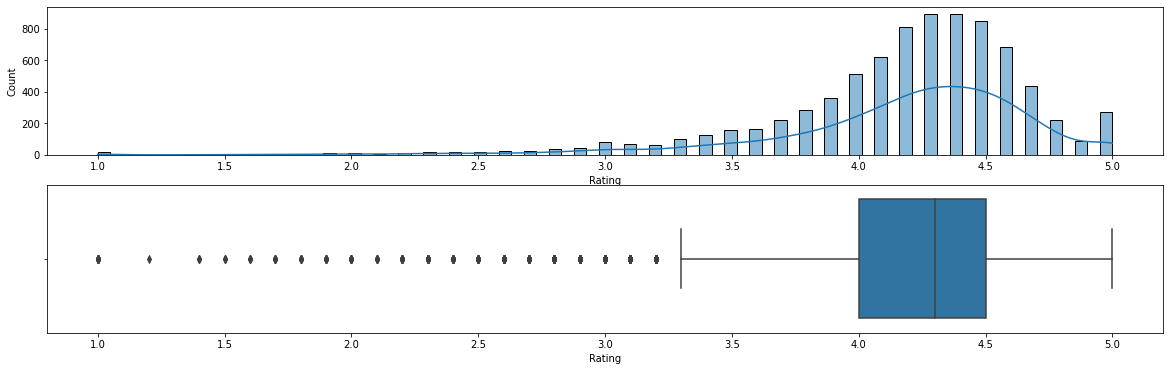

In [27]:
fig, axes = plt.subplots(2,1, figsize=(20,6));
sns.histplot(data=data_apps, x="Rating", kde=True, ax=axes[0])
sns.boxplot(data=data_apps, x="Rating", ax=axes[1])

In [28]:
# data_apps["Rating"].median()
data_apps["Rating"].describe()

count    8197.000000
mean        4.173356
std         0.536280
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Let's see if there is a relationship between the number of reviews and the rating. The graph seems to indicate that apps with a rating between 4 and 4.7 have a much higher number of reviews; kind of follows the same distribution as Rating.

<AxesSubplot:xlabel='Rating', ylabel='Reviews'>

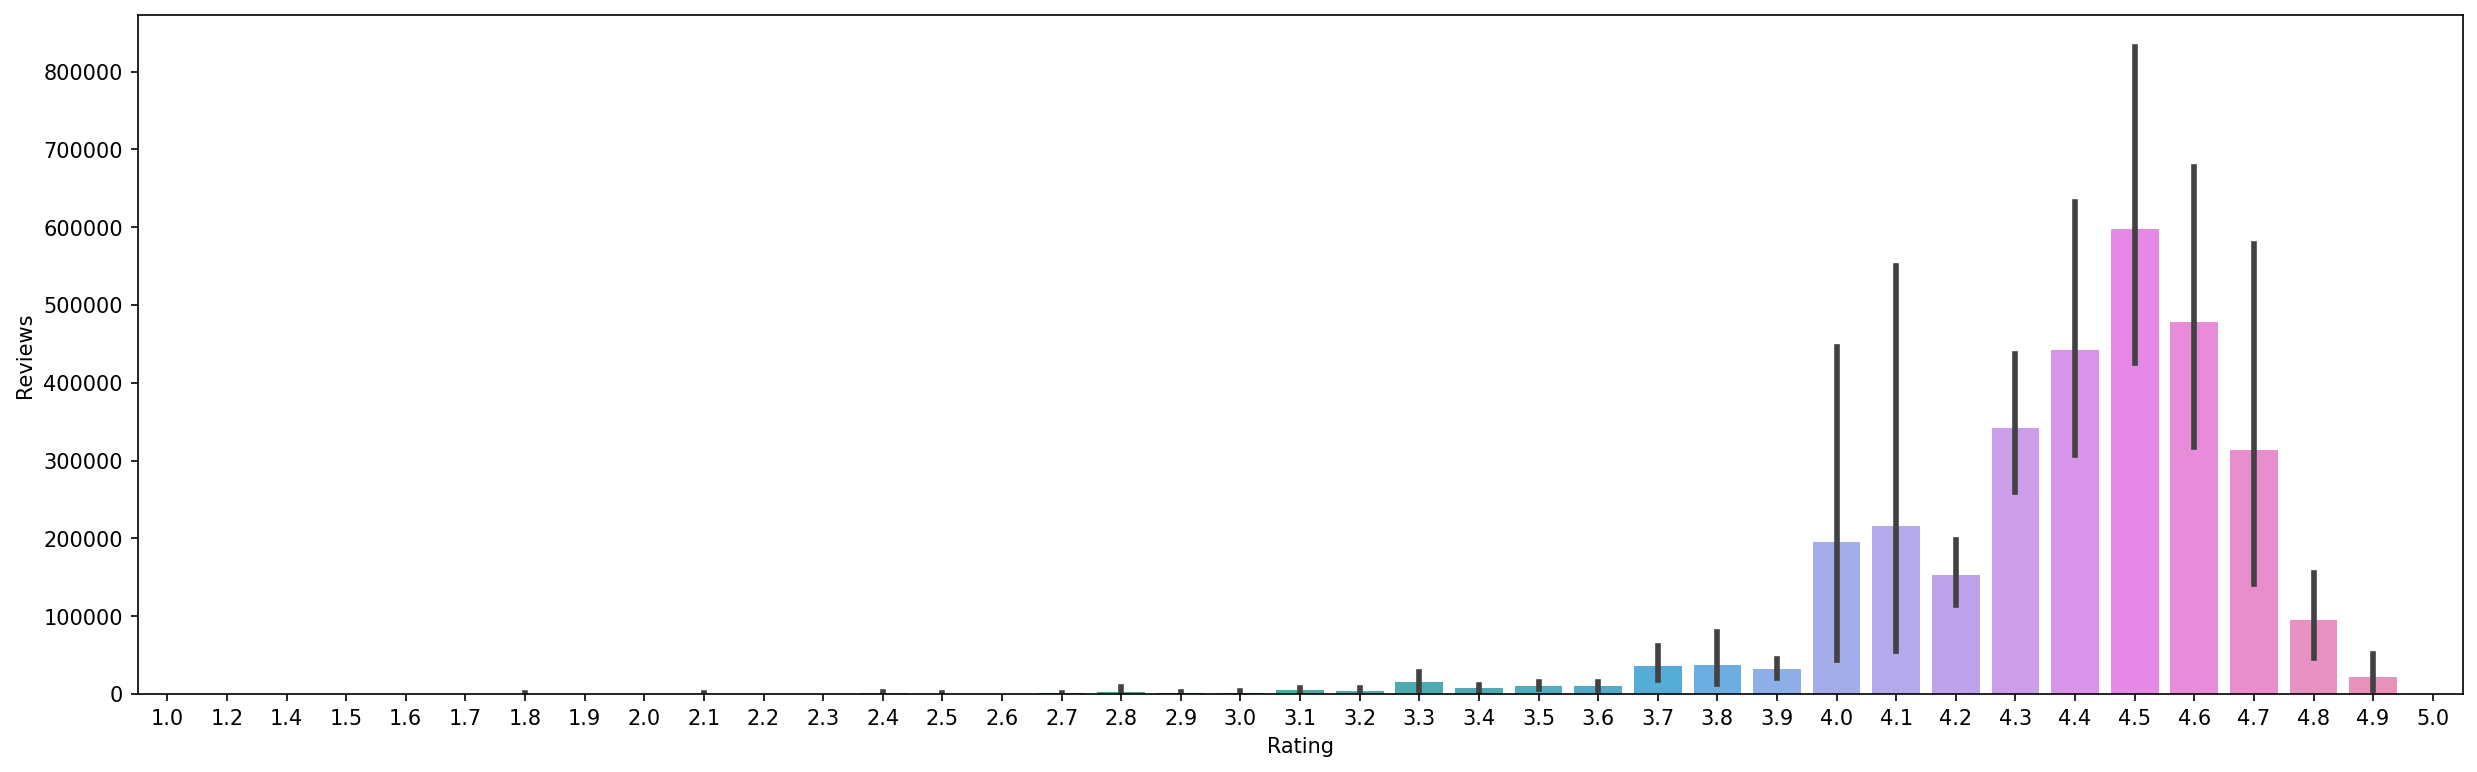

In [29]:
plt.figure(figsize=(20,6), dpi=150);
sns.barplot(data=data_apps, x="Rating", y="Reviews")

Let's take a look at the reviews. In the first plot we can see the boxplot for all the values, and we can observe some outliers, some apps with a very high number of reviews. Most have much less.

(-5000.0, 500000.0)

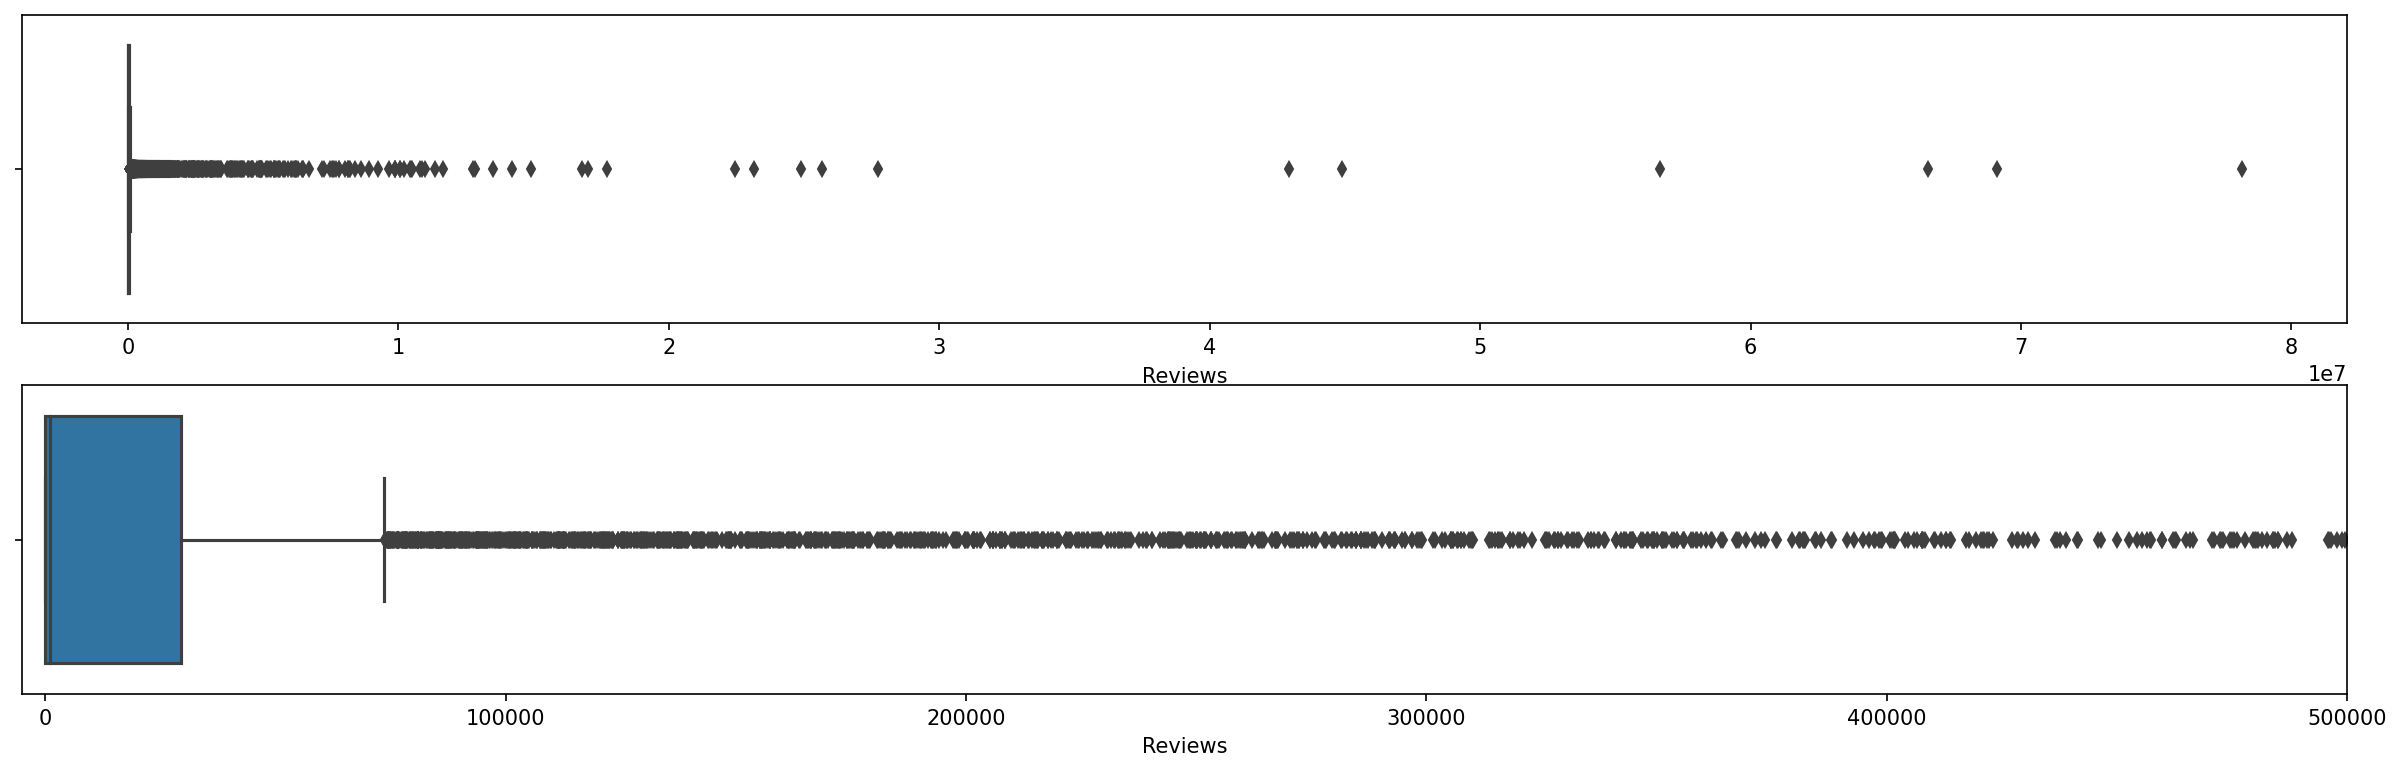

In [30]:
fig, axes = plt.subplots(2,1, figsize=(20,6), dpi=150)
sns.boxplot(data=data_apps, x="Reviews", ax=axes[0])
sns.boxplot(data=data_apps, x="Reviews", ax=axes[1])
plt.xlim(-5000, 500000)

Here we can see those apps with many reviews, such as Facebook, Whatasapp, Instagram. In this case, our outliers in Reviews are well-known and popularly used Apps. However, they represent phenomena that can happen with some apps, so we're not going to remove them from the dataset.

Perhaps we can try retraining the models without information about these apps, and evaluate the differences.

In [31]:
data_apps.sort_values(by="Reviews", ascending=False).head(5)

App       Category  Rating  \
2544                                  Facebook         SOCIAL     4.1   
336                         WhatsApp Messenger  COMMUNICATION     4.4   
2604                                 Instagram         SOCIAL     4.5   
382   Messenger ‚Äì Text and Video Chat for Free  COMMUNICATION     4.0   
1879                            Clash of Clans           GAME     4.6   

       Reviews                Size        Installs  Type Price Content Rating  \
2544  78158306  Varies with device  1,000,000,000+  Free     0           Teen   
336   69119316  Varies with device  1,000,000,000+  Free     0       Everyone   
2604  66577446  Varies with device  1,000,000,000+  Free     0           Teen   
382   56646578  Varies with device  1,000,000,000+  Free     0       Everyone   
1879  44893888                 98M    100,000,000+  Free     0   Everyone 10+   

             Genres Last Updated         Current Ver         Android Ver  
2544         Social   03/08/2018  Varies with device  Varies with device  
336   Communication   03/08/2018  Varies with device  Varies with device  
2604         Social   31/07/2018  Varies with device  Varies with device  
382   Communication   01/08/2018  Varies with device  Varies with device  
1879       Strategy   15/07/2018           10.322.16          4.1 and up

For the feature Size we have a series of values in MB (M) and kB (k), and many entries with "Varies with device".
To convert it into a numeric variable, we are going to keep only the MB, doing a conversion for those in kB.
The rows with value "Varies with device" will be completed with the mean size.

In [32]:
data_apps["Size"].value_counts()
#data_apps["Size"].unique()

Varies with device    1228
11M                    182
12M                    181
14M                    178
13M                    177
                      ... 
430k                     1
429k                     1
200k                     1
460k                     1
619k                     1
Name: Size, Length: 461, dtype: int64

In [33]:
# Function to obtain a numerical value for the feature Size.
# If it has a "M", we keep it that way.
# If it has a "k", we convert it to MB.
# If the value is "Varies with device", we return np.NaN to later fill it with the mean size.
def from_kb_to_mb(size):
    if "M" in size:
        return float(size[:-1]) # we skip last char => M
    if "k" in size:
        return round(float(size[:-1]) / 1024) # round => to have only 1 decimal, just as M has
    
    return np.NaN

In [34]:
data_apps["Size"] = data_apps["Size"].map(from_kb_to_mb)

mean_size = round(data_apps["Size"].mean(), 1)
data_apps["Size"] = data_apps["Size"].fillna(value=mean_size)

Now that the feature is numeric, let's look at a boxplot. Most apps are less than 50MB in size.

<AxesSubplot:xlabel='Size'>

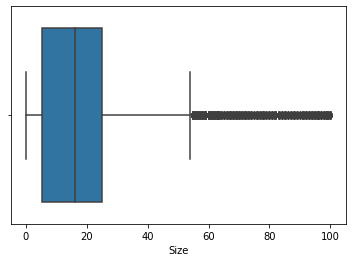

In [35]:
sns.boxplot(data=data_apps, x="Size")

Let's see if there is a relationship between Size and Rating. No trend or clear relationship between the two is observed.

<AxesSubplot:xlabel='Rating', ylabel='Size'>

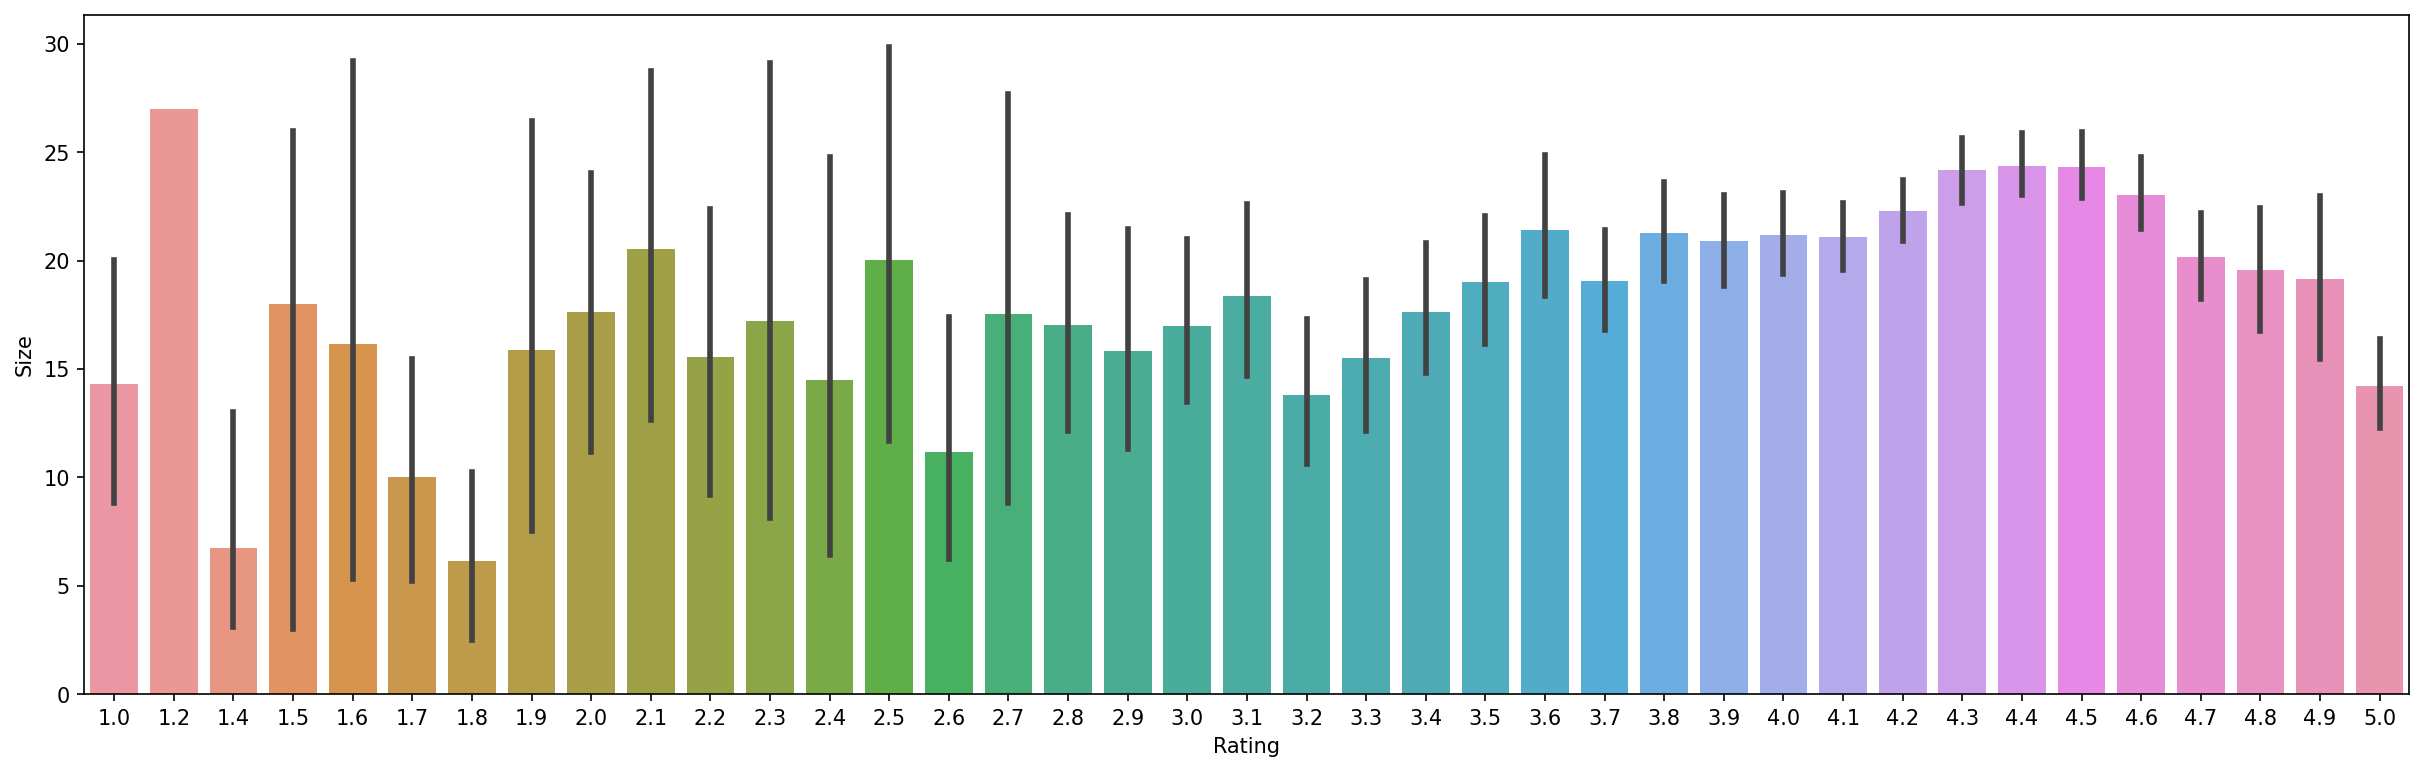

In [36]:
plt.figure(figsize=(20,6), dpi=150);
sns.barplot(data=data_apps, x="Rating", y="Size")

Let's now analyze the "Installs" feature. It has a series of categorical values (more than 10000 installs, etc). Since there is an order between them, we are going to change it to numerical values, removing the "+" from all of them.

In [37]:
data_apps["Installs"].value_counts()

1,000,000+        1417
100,000+          1113
10,000+           1030
10,000,000+        937
1,000+             887
100+               709
5,000,000+         607
500,000+           505
50,000+            469
5,000+             468
10+                385
500+               328
50,000,000+        204
50+                204
100,000,000+       189
5+                  82
1+                  67
500,000,000+        24
1,000,000,000+      20
0+                  14
0                    1
Name: Installs, dtype: int64

In [38]:
# Function to return the value of "installs" as numerical value
def installs_to_num(installs):
    if "+" in installs:
        installs = installs[:-1]
    installs = installs.replace(",", "")
    return int(installs)

data_apps["Installs"] = data_apps["Installs"].map(installs_to_num)

Let's take a look at how Installs behaves. Here we also have some outliers with a large number of installs. Possibly the same thing that happens with reviews for very popular apps like Facebook or Instagram.

<AxesSubplot:xlabel='Installs'>

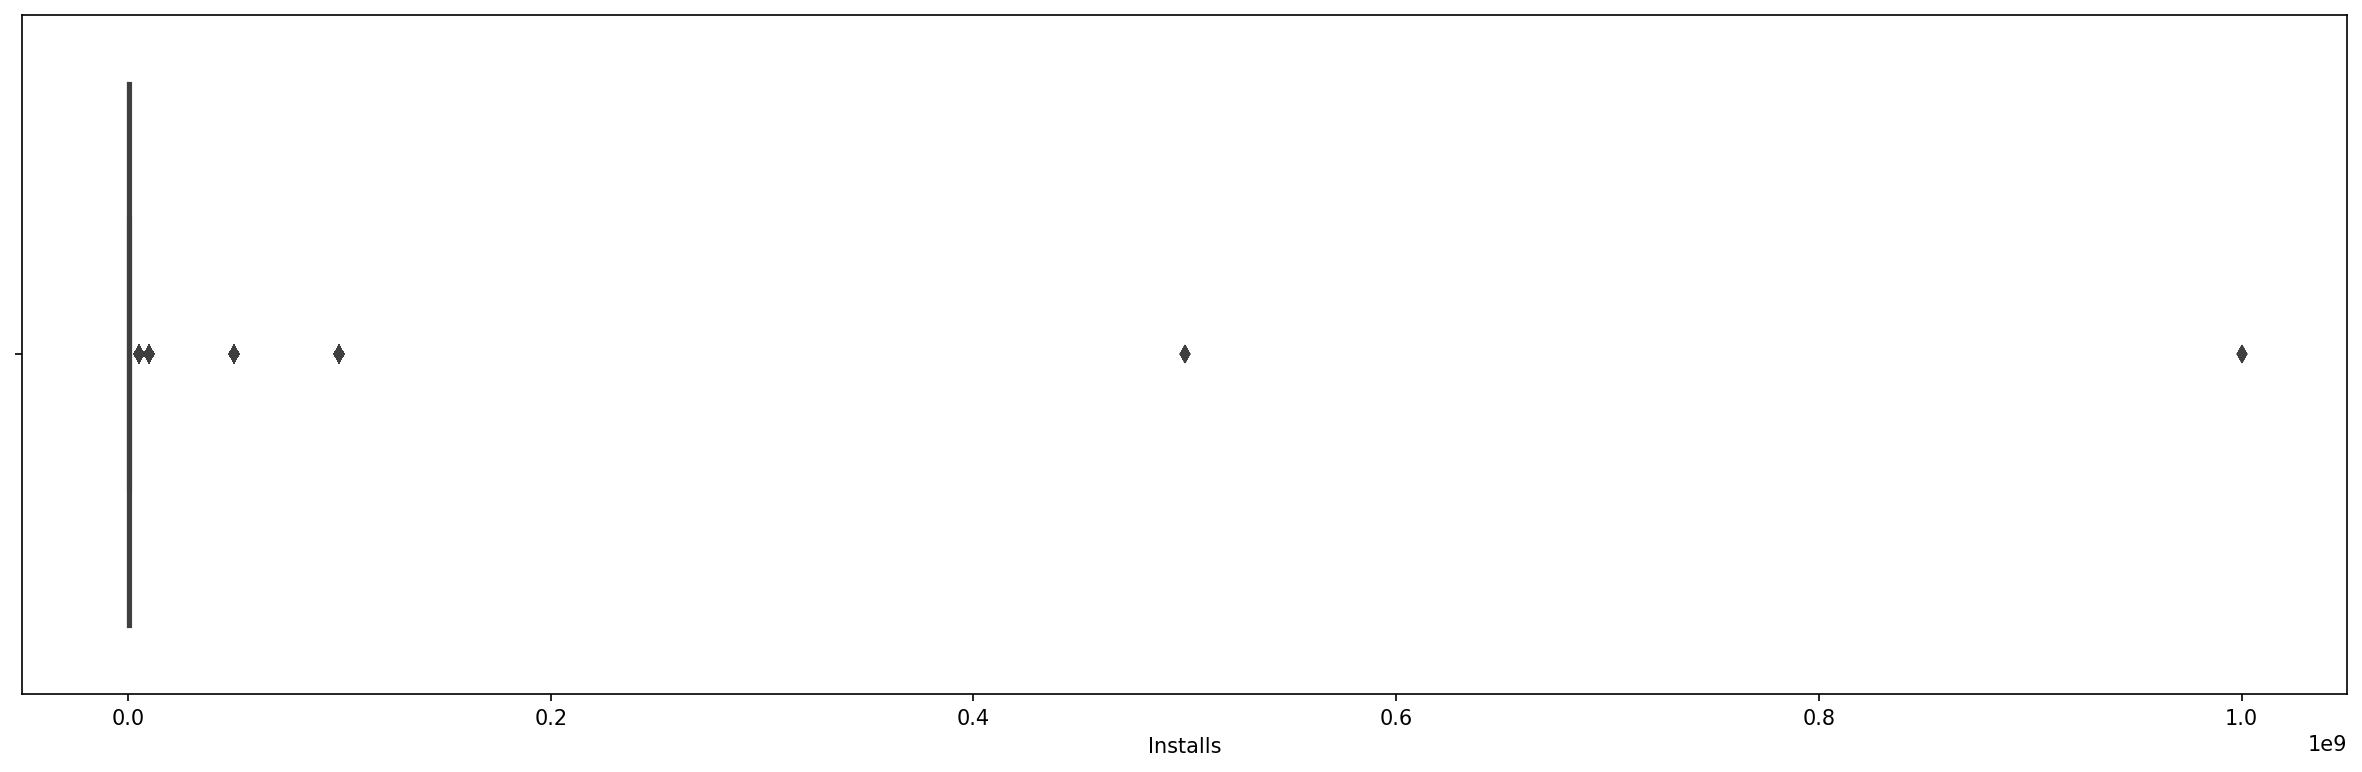

In [39]:
plt.figure(figsize=(20,6), dpi=150);
sns.boxplot(data=data_apps, x="Installs")

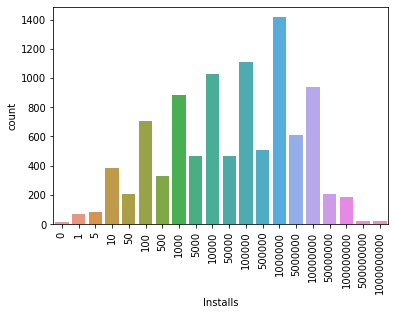

In [40]:
# data_apps.sort_values(by="Installs", ascending=False).head(5)
# data_apps["Installs"].value_counts()

sns.countplot(data=data_apps, x="Installs")
plt.xticks(rotation=90);

Let's observe the relationship between Installs and Rating ==> there is a growing trend, the more installations, the more rating (with some exceptions with few installations).

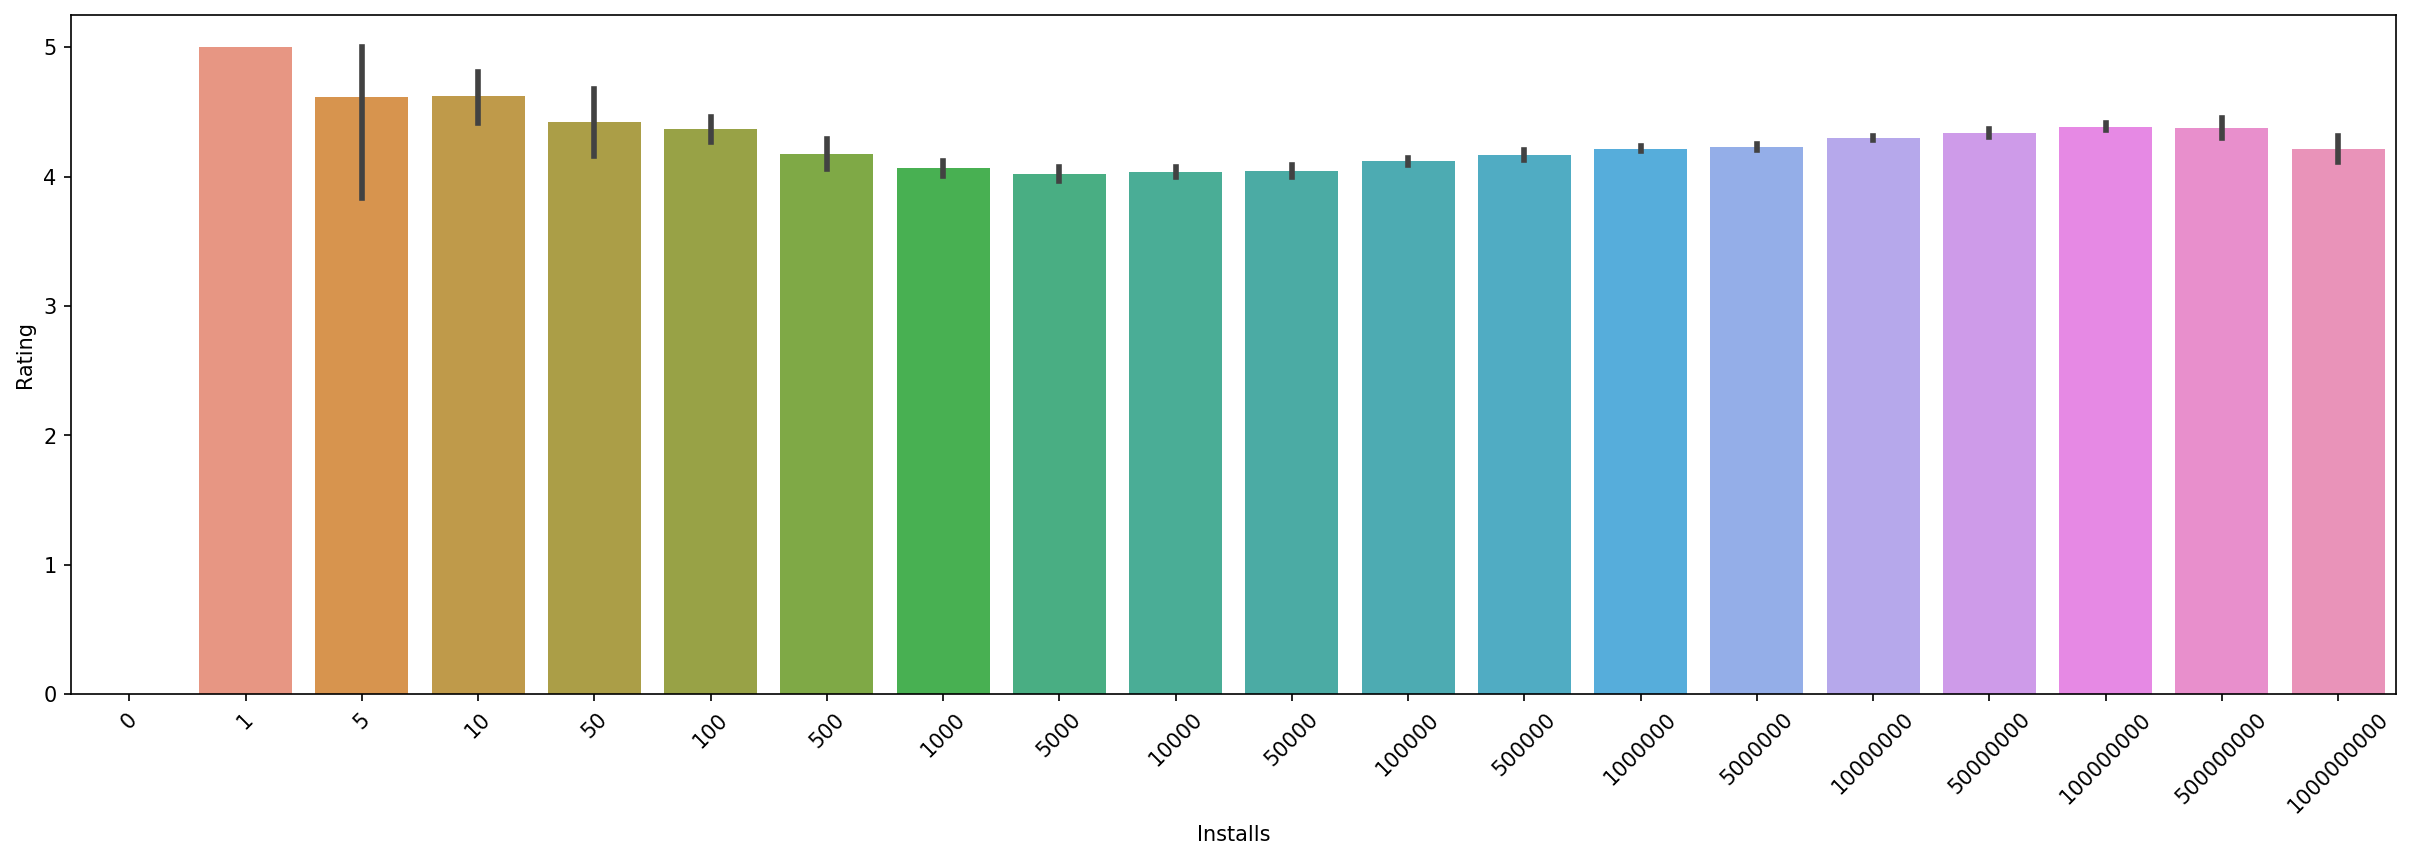

In [41]:
plt.figure(figsize=(20,6), dpi=150);
sns.barplot(data=data_apps, x="Installs", y="Rating")
plt.xticks(rotation=45);

Now let's see what happens with the "Price" feature. Here the "$" symbol is used, which makes it impossible for us to treat the feature as numeric, so we are going to remove it.

In [42]:
data_apps["Price"].value_counts()

0           8906
$0.99        145
$2.99        124
$1.99         73
$4.99         70
            ... 
$389.99        1
$19.90         1
$1.75          1
$14.00         1
$1.04          1
Name: Price, Length: 92, dtype: int64

In [43]:
# Function to remove the "$" symbol.
def price_to_num(price):
    return float(price.replace("$", ""))

data_apps["Price"] = data_apps["Price"].map(price_to_num)

<AxesSubplot:xlabel='Price', ylabel='Count'>

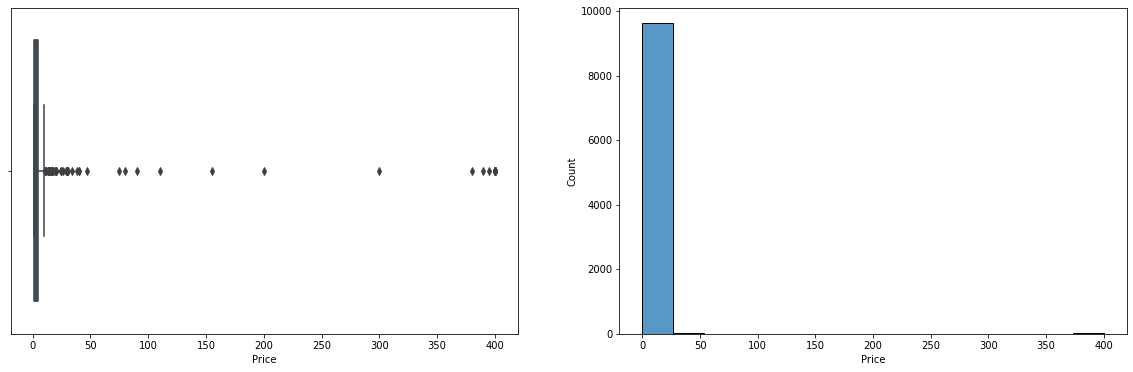

In [44]:
# Let's see the boxplot of the price (greater that 0)
fig, axes = plt.subplots(1,2, figsize=(20,6));
sns.boxplot(data=data_apps[data_apps["Price"] > 0], x="Price", ax=axes[0])
sns.histplot(data=data_apps, x=data_apps["Price"], ax=axes[1])

We have some very expensive apps. Looking at the dataset sorted by Price (highest to lowest) we see that those apps over $300 appear to be "meme" apps. At least they all seem to have the same spirit.

We are going to remove these outliers (those over 299.99).

In [45]:
data_apps.sort_values(by="Price", ascending=False).head(20)

App      Category  Rating  Reviews  Size  \
4367           I'm Rich - Trump Edition     LIFESTYLE     3.6      275   7.3   
5358                         I am Rich!       FINANCE     3.8       93  22.0   
9934  I'm Rich/Eu sou Rico/ÿ£ŸÜÿß ÿ∫ŸÜŸä/ÊàëÂæàÊúâÈå¢     LIFESTYLE     NaN        0  40.0   
5373                 I AM RICH PRO PLUS       FINANCE     4.0       36  41.0   
5364     I am rich (Most expensive app)       FINANCE     4.1      129   2.7   
5362                      I Am Rich Pro        FAMILY     4.4      201   2.7   
5359                 I am rich(premium)       FINANCE     3.5      472   1.0   
4197             most expensive app (H)        FAMILY     4.3        6   1.5   
5354                     I am Rich Plus        FAMILY     4.0      856   8.7   
5351                          I am rich     LIFESTYLE     3.8     3547   1.8   
5356                  I Am Rich Premium       FINANCE     4.1     1867   4.7   
4362                         üíé I'm rich     LIFESTYLE     3.8      718  26.0   
5369                          I am Rich       FINANCE     4.3      180   3.8   
9917                        Eu Sou Rico       FINANCE     NaN        0   1.4   
5366                          I Am Rich        FAMILY     3.6      217   4.9   
5357                I am extremely Rich     LIFESTYLE     2.9       41   2.9   
5355                      I am rich VIP     LIFESTYLE     3.8      411   2.6   
9719                       EP Cook Book       MEDICAL     NaN        0   3.2   
6692                      cronometra-br  PRODUCTIVITY     NaN        0   5.4   
6624            BP Fitness Lead Scanner        EVENTS     NaN        0   6.7   

      Installs  Type   Price Content Rating         Genres Last Updated  \
4367     10000  Paid  400.00       Everyone      Lifestyle   03/05/2018   
5358      1000  Paid  399.99       Everyone        Finance   11/12/2017   
9934         0  Paid  399.99       Everyone      Lifestyle   01/12/2017   
5373      1000  Paid  399.99       Everyone        Finance   25/06/2018   
5364      1000  Paid  399.99           Teen        Finance   06/12/2017   
5362      5000  Paid  399.99       Everyone  Entertainment   30/05/2017   
5359      5000  Paid  399.99       Everyone        Finance   01/05/2017   
4197       100  Paid  399.99       Everyone  Entertainment   16/07/2018   
5354     10000  Paid  399.99       Everyone  Entertainment   19/05/2018   
5351    100000  Paid  399.99       Everyone      Lifestyle   12/01/2018   
5356     50000  Paid  399.99       Everyone        Finance   12/11/2017   
4362     10000  Paid  399.99       Everyone      Lifestyle   11/03/2018   
5369      5000  Paid  399.99       Everyone        Finance   22/03/2018   
9917         0  Paid  394.99       Everyone        Finance   11/07/2018   
5366     10000  Paid  389.99       Everyone  Entertainment   22/06/2018   
5357      1000  Paid  379.99       Everyone      Lifestyle   01/07/2018   
5355     10000  Paid  299.99       Everyone      Lifestyle   21/07/2018   
9719         0  Paid  200.00       Everyone        Medical   26/07/2015   
6692         0  Paid  154.99       Everyone   Productivity   24/11/2017   
6624         1  Paid  109.99       Everyone         Events   23/08/2017   

     Current Ver   Android Ver  
4367       1.0.1    4.1 and up  
5358           1    4.1 and up  
9934       MONEY    4.1 and up  
5373       1.0.2    4.1 and up  
5364           2  4.0.3 and up  
5362        1.54    1.6 and up  
5359         3.4    4.4 and up  
4197           1    7.0 and up  
5354           3    4.4 and up  
5351           2  4.0.3 and up  
5356         1.6    4.0 and up  
4362       1.0.0    4.4 and up  
5369           1    4.2 and up  
9917           1  4.0.3 and up  
5366         1.5    4.2 and up  
5357           1    4.0 and up  
5355       1.1.1    4.3 and up  
9719           1    3.0 and up  
6692       1.0.0    4.1 and up  
6624       0.0.1    4.1 and up

In [46]:
# Removing the outliers => those apps with price greater than $200, that are all "I am rich" apps variations
data_apps = data_apps.drop(data_apps[data_apps["Price"] > 200].index)

<AxesSubplot:xlabel='Price'>

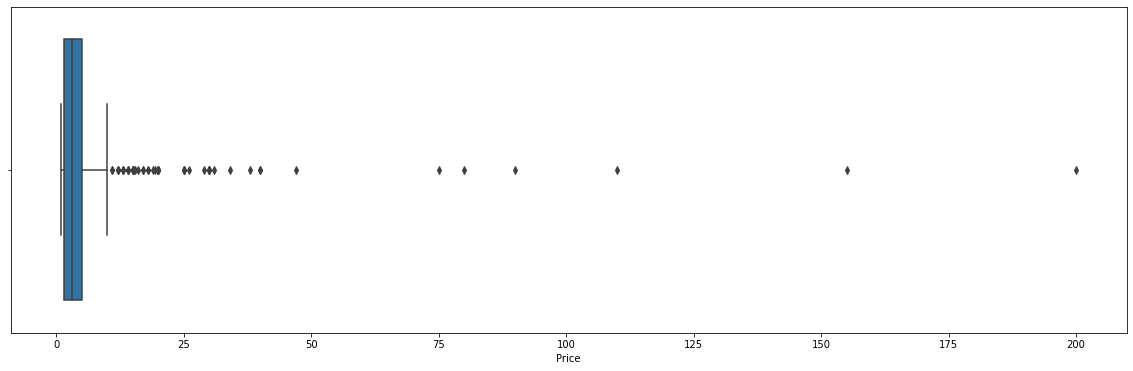

In [47]:
# Boxplot without outliers
# Most of the apps cost less than $10
plt.figure(figsize=(20,6));
sns.boxplot(data=data_apps[data_apps["Price"] > 0], x="Price")

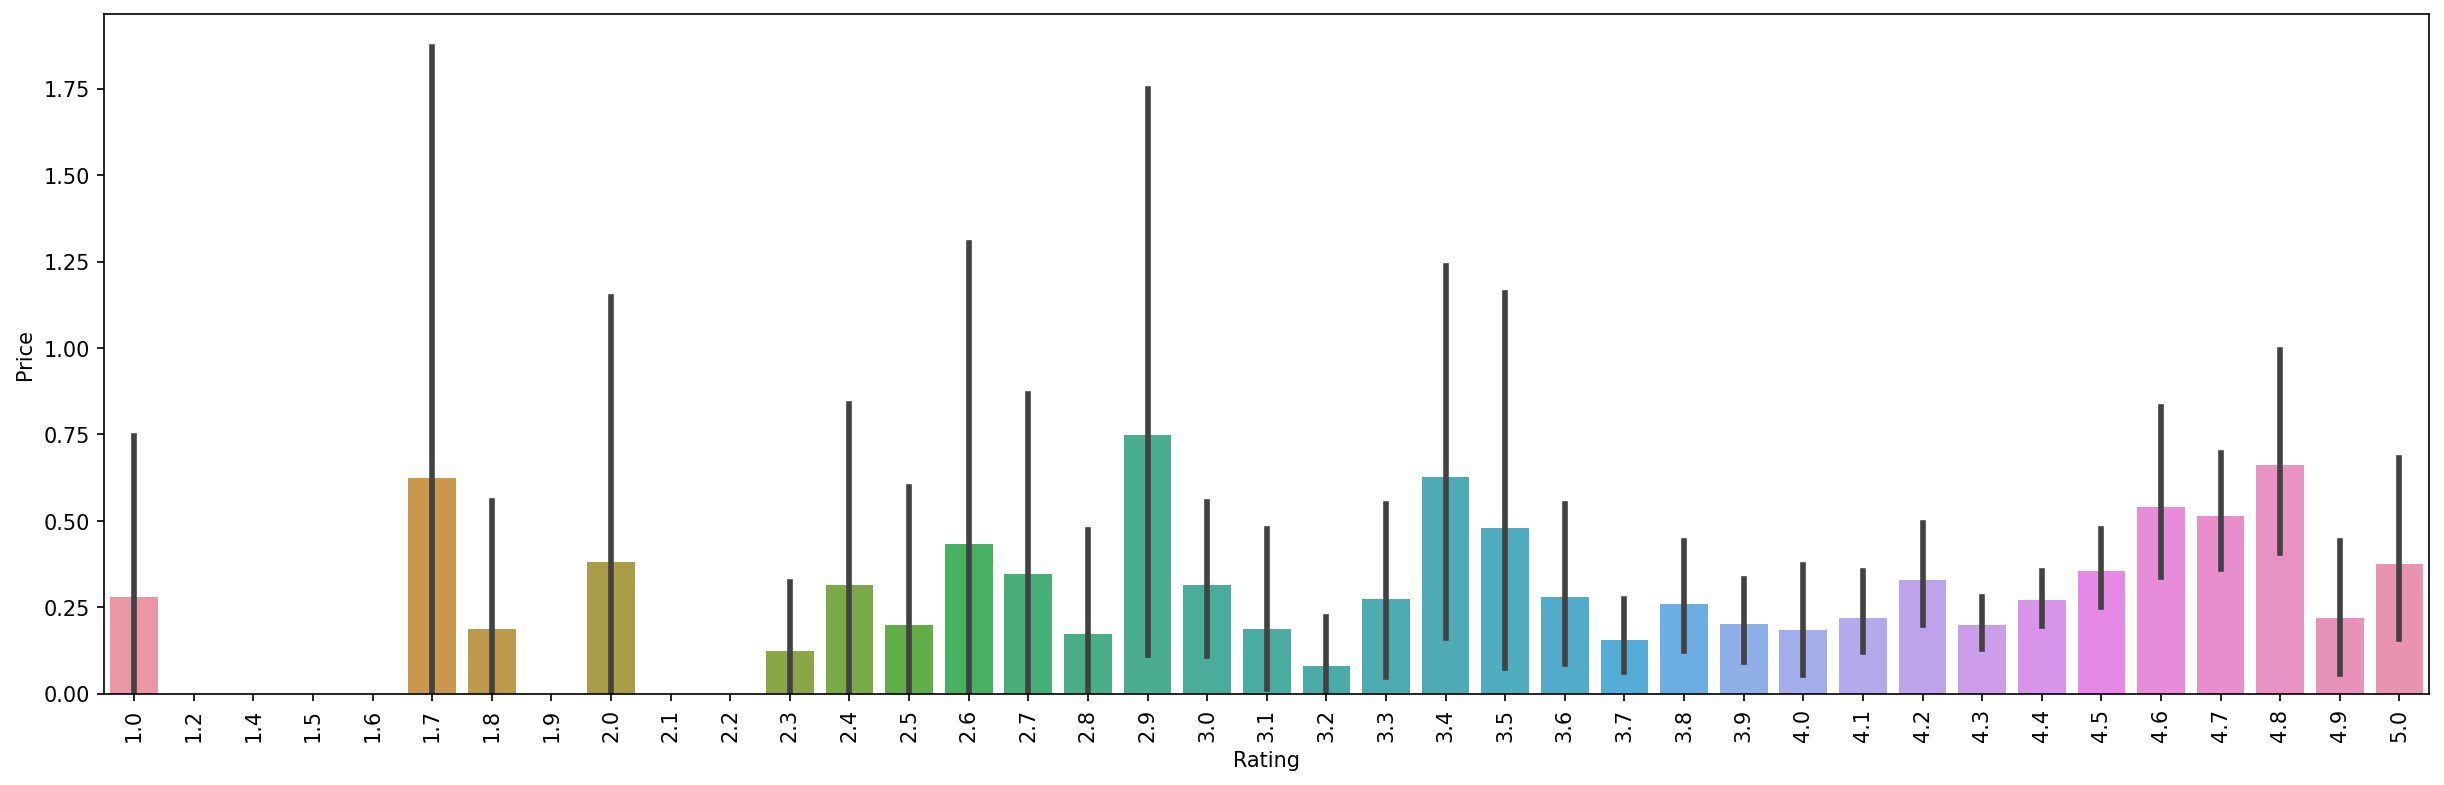

In [48]:
# Relation between Price and Rating. We can't observe a clear relationship.
plt.figure(figsize=(20,6), dpi=150);
sns.barplot(data=data_apps, x="Rating", y="Price")
plt.xticks(rotation=90);

Although Last Updated is not numeric, it is ordinal => let's pass it to datetime and see if there is any trend.

In [49]:
data_apps['Last Updated'] = pd.to_datetime(data_apps['Last Updated'], format="%d/%m/%Y")
data_apps["Last Updated"] 

0       2018-01-07
2       2018-08-01
3       2018-06-08
4       2018-06-20
5       2017-03-26
           ...    
10837   2018-07-06
10838   2017-01-20
10839   2015-01-19
10840   2018-07-25
10841   2018-03-09
Name: Last Updated, Length: 9643, dtype: datetime64[ns]

<AxesSubplot:xlabel='Last Updated', ylabel='Count'>

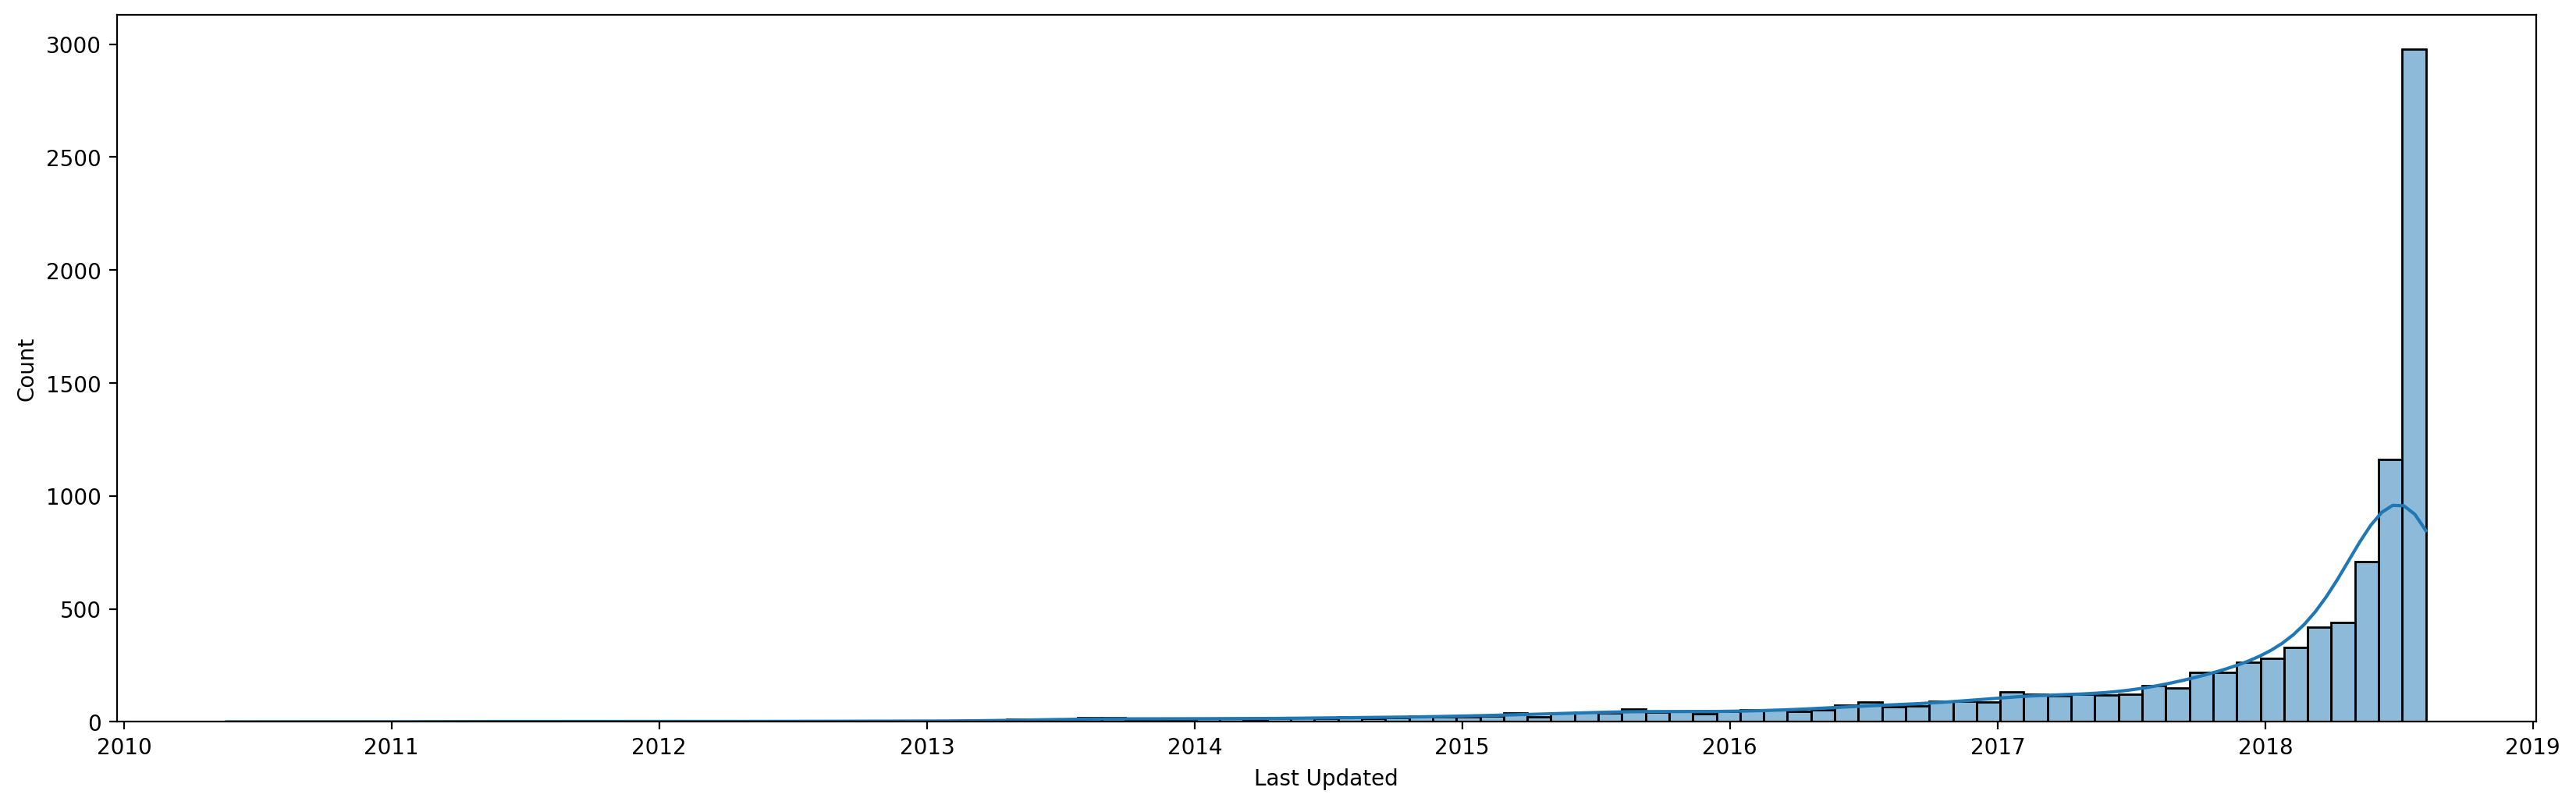

In [50]:
plt.figure(figsize=(20,6), dpi=200);
sns.histplot(data=data_apps, x="Last Updated", kde=True)

Let's simplify to checking only the years. We can see that most of the apps were recently updated.

<AxesSubplot:xlabel='Year Updated', ylabel='count'>

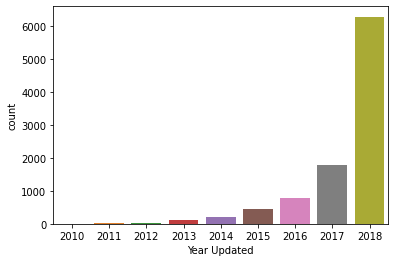

In [51]:
data_apps["Year Updated"] = data_apps["Last Updated"].dt.year
sns.countplot(data=data_apps, x="Year Updated")

<AxesSubplot:xlabel='Year Updated', ylabel='Rating'>

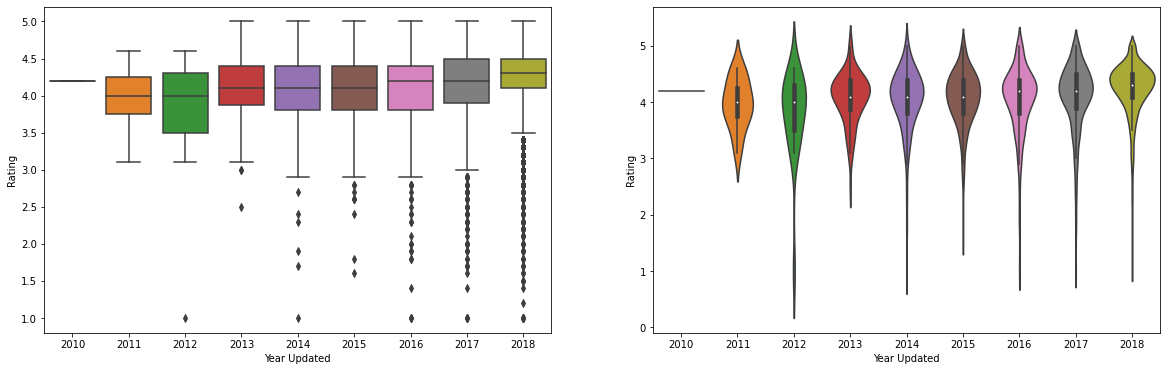

In [52]:
# Relation between year of last update and rating of the app.
fig, axes = plt.subplots(1, 2, figsize=(20, 6));
sns.boxplot(data=data_apps, x="Year Updated", y="Rating", ax=axes[0])
sns.violinplot(data=data_apps, x='Year Updated', y='Rating', ax=axes[1])

For Current Ver we can see that we have a wide variety of possible versions. Let's simplify this data by using only the first number as the version to get an idea of how the data is distributed.

In [53]:
data_apps["Current Ver"].value_counts()
#sns.boxplot(x=data_apps["Current Ver"])

Varies with device    1063
1                      825
1.1                    272
1.2                    183
2                      161
                      ... 
0.1.187945513            1
2.2.194                  1
68.0.3440.91             1
4.8.2.2195               1
2.0.148.0                1
Name: Current Ver, Length: 2770, dtype: int64

In [54]:
import re 

def simplified_app_version(version):
    if type(version) != str:
        return version
    
    results = re.findall(r'(\d)[\.\d+]*', version)
    if results:
        return int(results[0])
    else: # All the "Varies with device" and the outliers (as "final", "DH-Security Camera", etc)
        return np.NaN

data_apps["Simplified App Ver"] = data_apps["Current Ver"].map(simplified_app_version)
data_apps["Simplified App Ver"].value_counts()

1.0    4485
2.0    1489
3.0     902
4.0     566
5.0     366
6.0     244
0.0     166
7.0     159
8.0     124
9.0      63
Name: Simplified App Ver, dtype: int64

<AxesSubplot:xlabel='Simplified App Ver'>

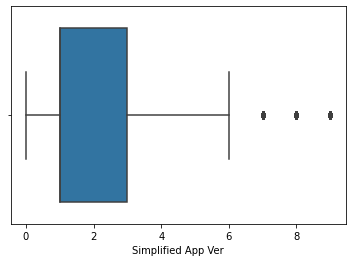

In [55]:
# Most of the versions are between 0 and 6. Higher versions are outliers.
sns.boxplot(data=data_apps, x="Simplified App Ver")

In [56]:
# We completed some versions as "na", let's count how many.
data_apps["Simplified App Ver"].isna().sum()

1079

<AxesSubplot:xlabel='Simplified App Ver', ylabel='Rating'>

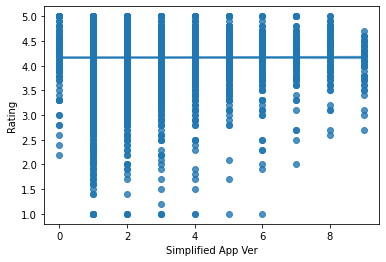

In [57]:
# Let's see if the version of the app impacts in the rating. We can't observe any relation between both.
sns.regplot(data=data_apps, x="Simplified App Ver", y="Rating") 

<AxesSubplot:xlabel='Simplified App Ver', ylabel='Reviews'>

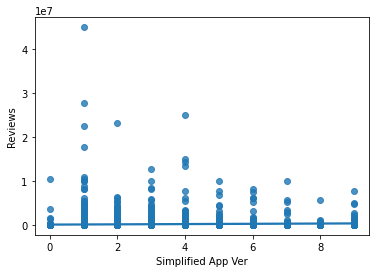

In [58]:
# Relation between version and reviews
sns.regplot(data=data_apps, x="Simplified App Ver", y="Reviews")

We are not going to use the version of the app to predict the Rating. Let's see what happens with the Android version.

Here we also have to clean up the data a bit. We are going to simplify the version by using only the first number and assuming that the version implies that it accepts that number and those that follow.

In [59]:
data_apps["Android Ver"].value_counts()

4.1 and up            2201
4.0.3 and up          1391
4.0 and up            1284
Varies with device     993
4.4 and up             815
2.3 and up             614
5.0 and up             512
4.2 and up             370
2.3.3 and up           273
2.2 and up             239
3.0 and up             230
4.3 and up             220
2.1 and up             133
1.6 and up             115
6.0 and up              54
7.0 and up              41
3.2 and up              36
2.0 and up              32
5.1 and up              22
1.5 and up              20
4.4W and up             11
3.1 and up              10
2.0.1 and up             7
8.0 and up               6
7.1 and up               3
4.0.3 - 7.1.1            2
5.0 - 8.0                2
1.0 and up               2
7.0 - 7.1.1              1
4.1 - 7.1.1              1
5.0 - 6.0                1
2.2 - 7.1.1              1
5.0 - 7.1.1              1
Name: Android Ver, dtype: int64

In [60]:
# We can simplify the version using only the first number
def simplified_android_version(version):
    if type(version) != str:
        return version
    results = re.findall(r'(\d+)[\.\d+]*', version)
    if results:
        return int(results[0])
    else: # all those that have "Varies with device"
        return np.NaN

data_apps["Simplified Android Ver"] = data_apps["Android Ver"].map(simplified_android_version)

In [61]:
# Most of the apps have android version 4 or higher
data_apps["Simplified Android Ver"].value_counts()

4.0    6295
2.0    1299
5.0     538
3.0     276
1.0     137
6.0      54
7.0      45
8.0       6
Name: Simplified Android Ver, dtype: int64

<AxesSubplot:xlabel='Simplified Android Ver', ylabel='Count'>

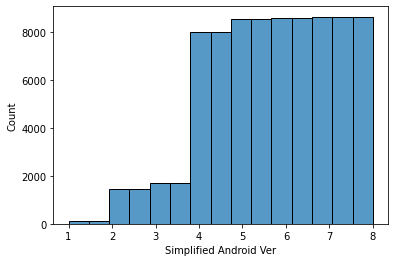

In [62]:
sns.histplot(data=data_apps, x="Simplified Android Ver", cumulative=True) 
# cumulative=True given that Simplified Android Ver means that works for that version and higher

Let's see if there is a relationship with the Rating. We can see that as the version is higher/newer, the higher the user scores tend to be.

<AxesSubplot:xlabel='Simplified Android Ver', ylabel='Rating'>

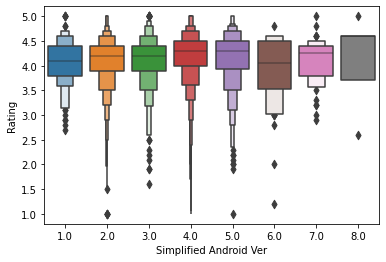

In [63]:
sns.boxenplot(data=data_apps, x="Simplified Android Ver", y="Rating") 

In [64]:
# data_apps[data_apps["Simplified Android Ver"].isna()]

We have some missing values. Let's complete the Android version with the average Android version per year.

In [65]:
group_year_agg_android = data_apps.groupby(["Year Updated"]).agg({"Simplified Android Ver": ["mean"]})
group_year_agg_android

Simplified Android Ver
                               mean
Year Updated                       
2010                       1.000000
2011                       1.466667
2012                       1.960000
2013                       1.932039
2014                       2.387755
2015                       2.776498
2016                       3.190476
2017                       3.540955
2018                       4.008450

In [66]:
def replace_varies_android_ver(row):
    if pd.isna(row["Simplified Android Ver"]):
        year = row["Year Updated"]
        return round(group_year_agg_android.loc[year, ("Simplified Android Ver", "mean")])
    else:
        return row["Simplified Android Ver"]
    
data_apps["Simplified Android Ver"] = data_apps.apply(replace_varies_android_ver, axis=1)

Let's see if there are correlations between the numerical variables.

In [67]:
data_apps.corr()

Rating   Reviews      Size  Installs     Price  \
Rating                  1.000000  0.055032  0.058834  0.040080  0.024343   
Reviews                 0.055032  1.000000  0.085624  0.625048 -0.012662   
Size                    0.058834  0.085624  1.000000  0.057840 -0.010970   
Installs                0.040080  0.625048  0.057840  1.000000 -0.016002   
Price                   0.024343 -0.012662 -0.010970 -0.016002  1.000000   
Year Updated            0.126439  0.058158  0.201226  0.068910 -0.065331   
Simplified App Ver      0.001621  0.052995  0.038910  0.070704 -0.023794   
Simplified Android Ver  0.060507  0.025696  0.131386  0.035141 -0.032083   

                        Year Updated  Simplified App Ver  \
Rating                      0.126439            0.001621   
Reviews                     0.058158            0.052995   
Size                        0.201226            0.038910   
Installs                    0.068910            0.070704   
Price                      -0.065331           -0.023794   
Year Updated                1.000000            0.172763   
Simplified App Ver          0.172763            1.000000   
Simplified Android Ver      0.526496            0.112329   

                        Simplified Android Ver  
Rating                                0.060507  
Reviews                               0.025696  
Size                                  0.131386  
Installs                              0.035141  
Price                                -0.032083  
Year Updated                          0.526496  
Simplified App Ver                    0.112329  
Simplified Android Ver                1.000000

<AxesSubplot:>

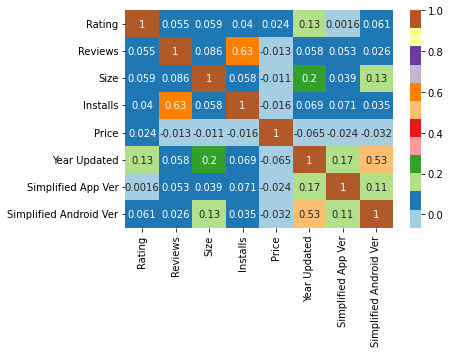

In [68]:
# The strongest correlations are between the number of Installs and Reviews; between Year Updated and Simplified Android View 
# --which makes sense; and then weaker correlations between Year Updated and Size, and Year Updated and Rating, Size and 
#Simplified Android Ver.

# Price is the one that seems least correlated with the rest.
sns.heatmap(data_apps.corr(), cmap="Paired", annot=True)

## Analysis of categorical features <a name="categoricalfeatures"></a>

Let's see how categorical features behave and what we should take into account. These features are:
- Category
- Genres
- Type
- Content Rating

Let's start with the Category and Genres features. Most popular categories: FAMILY, GAME and TOOLS.

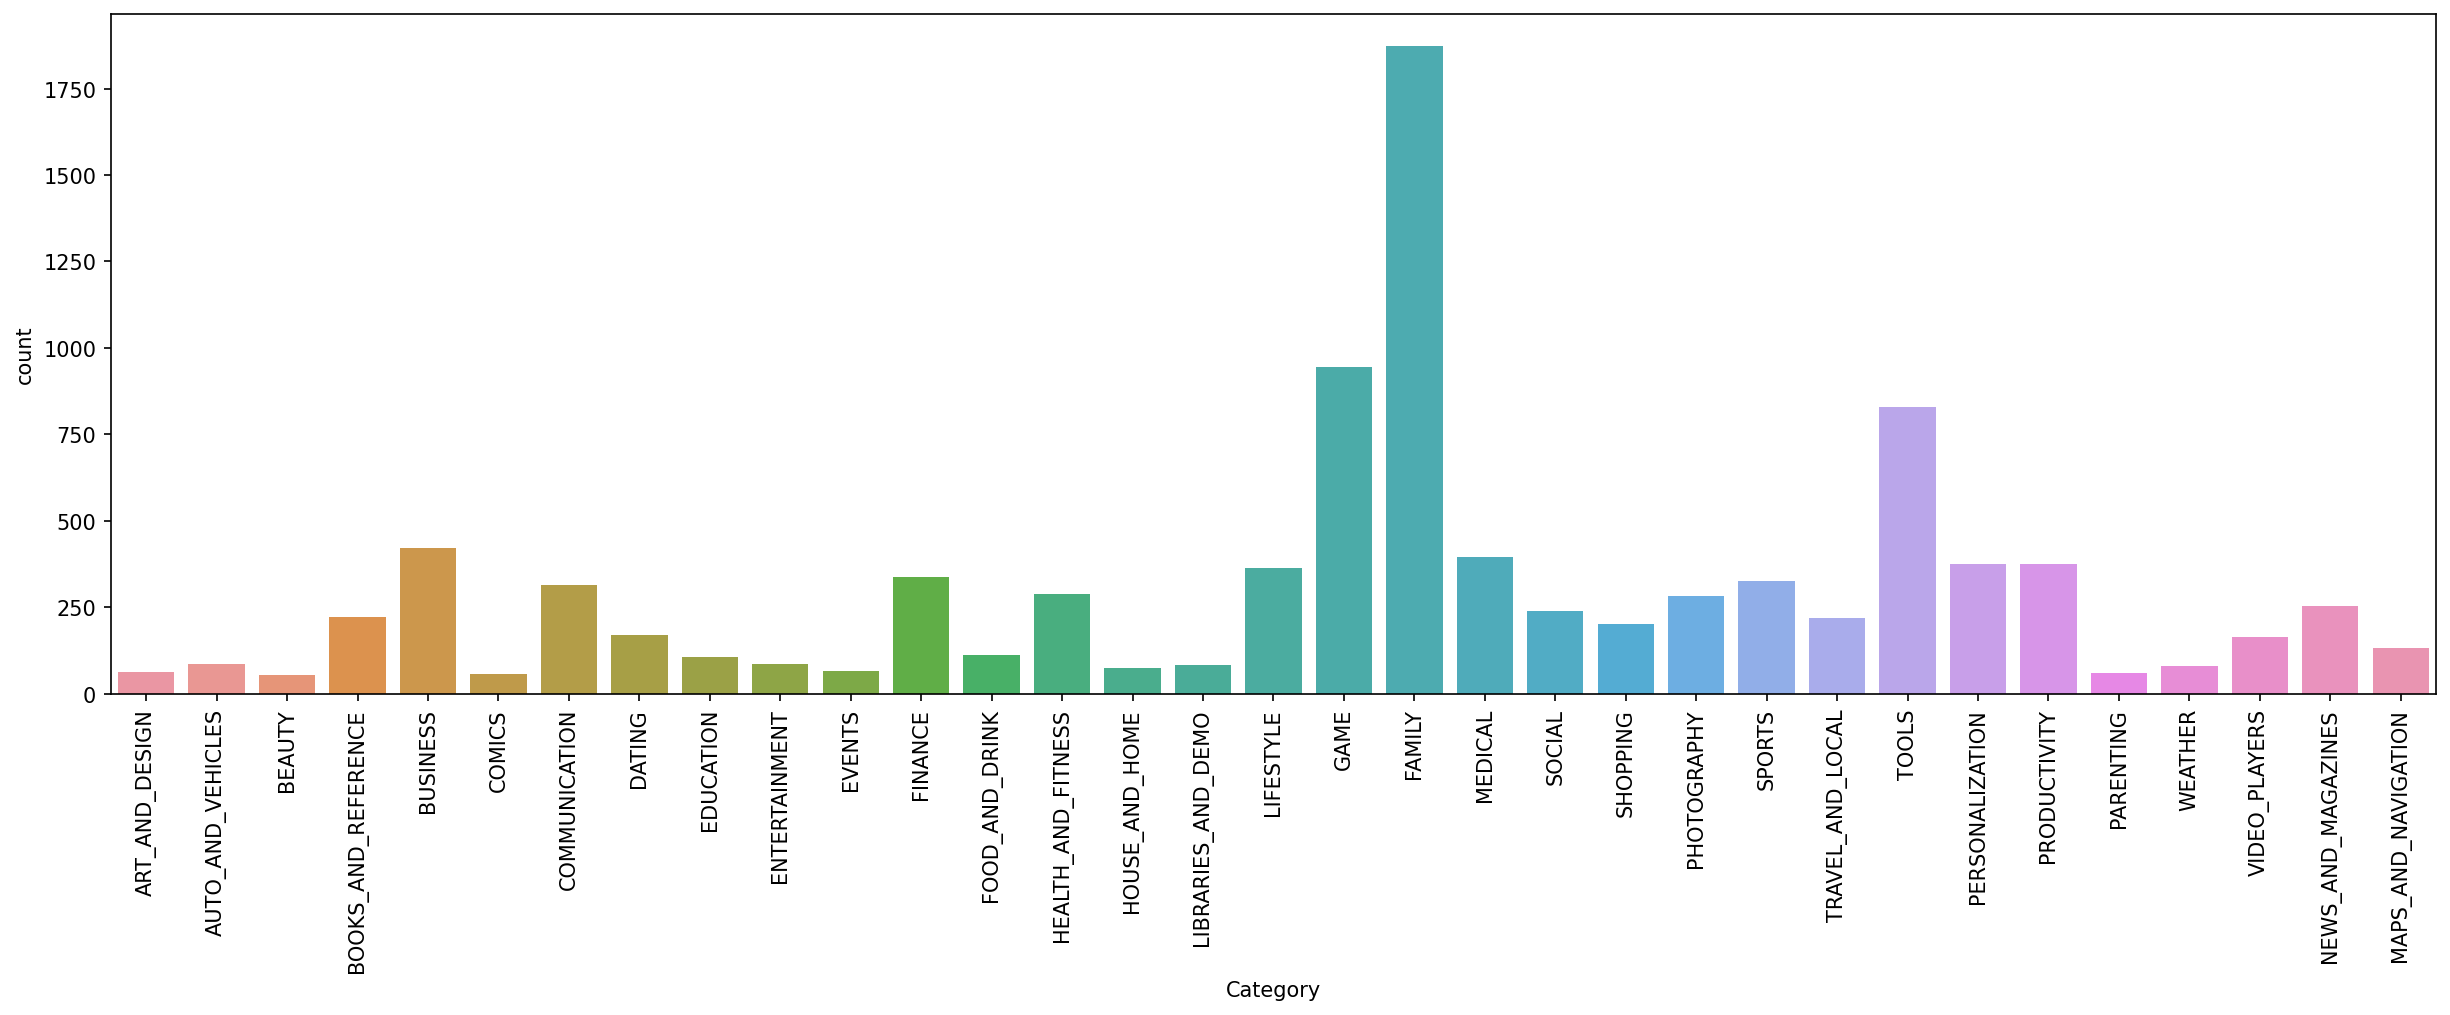

In [69]:
# data_apps["Category"].value_counts()
plt.figure(figsize=(20,6), dpi=150)
sns.countplot(data=data_apps, x="Category")
plt.xticks(rotation=90);

Let's look at the relationship between Category and Rating, and then look at the top rated categories on average: EVENTS, EDUCATION, ART_AND_DESIGN.

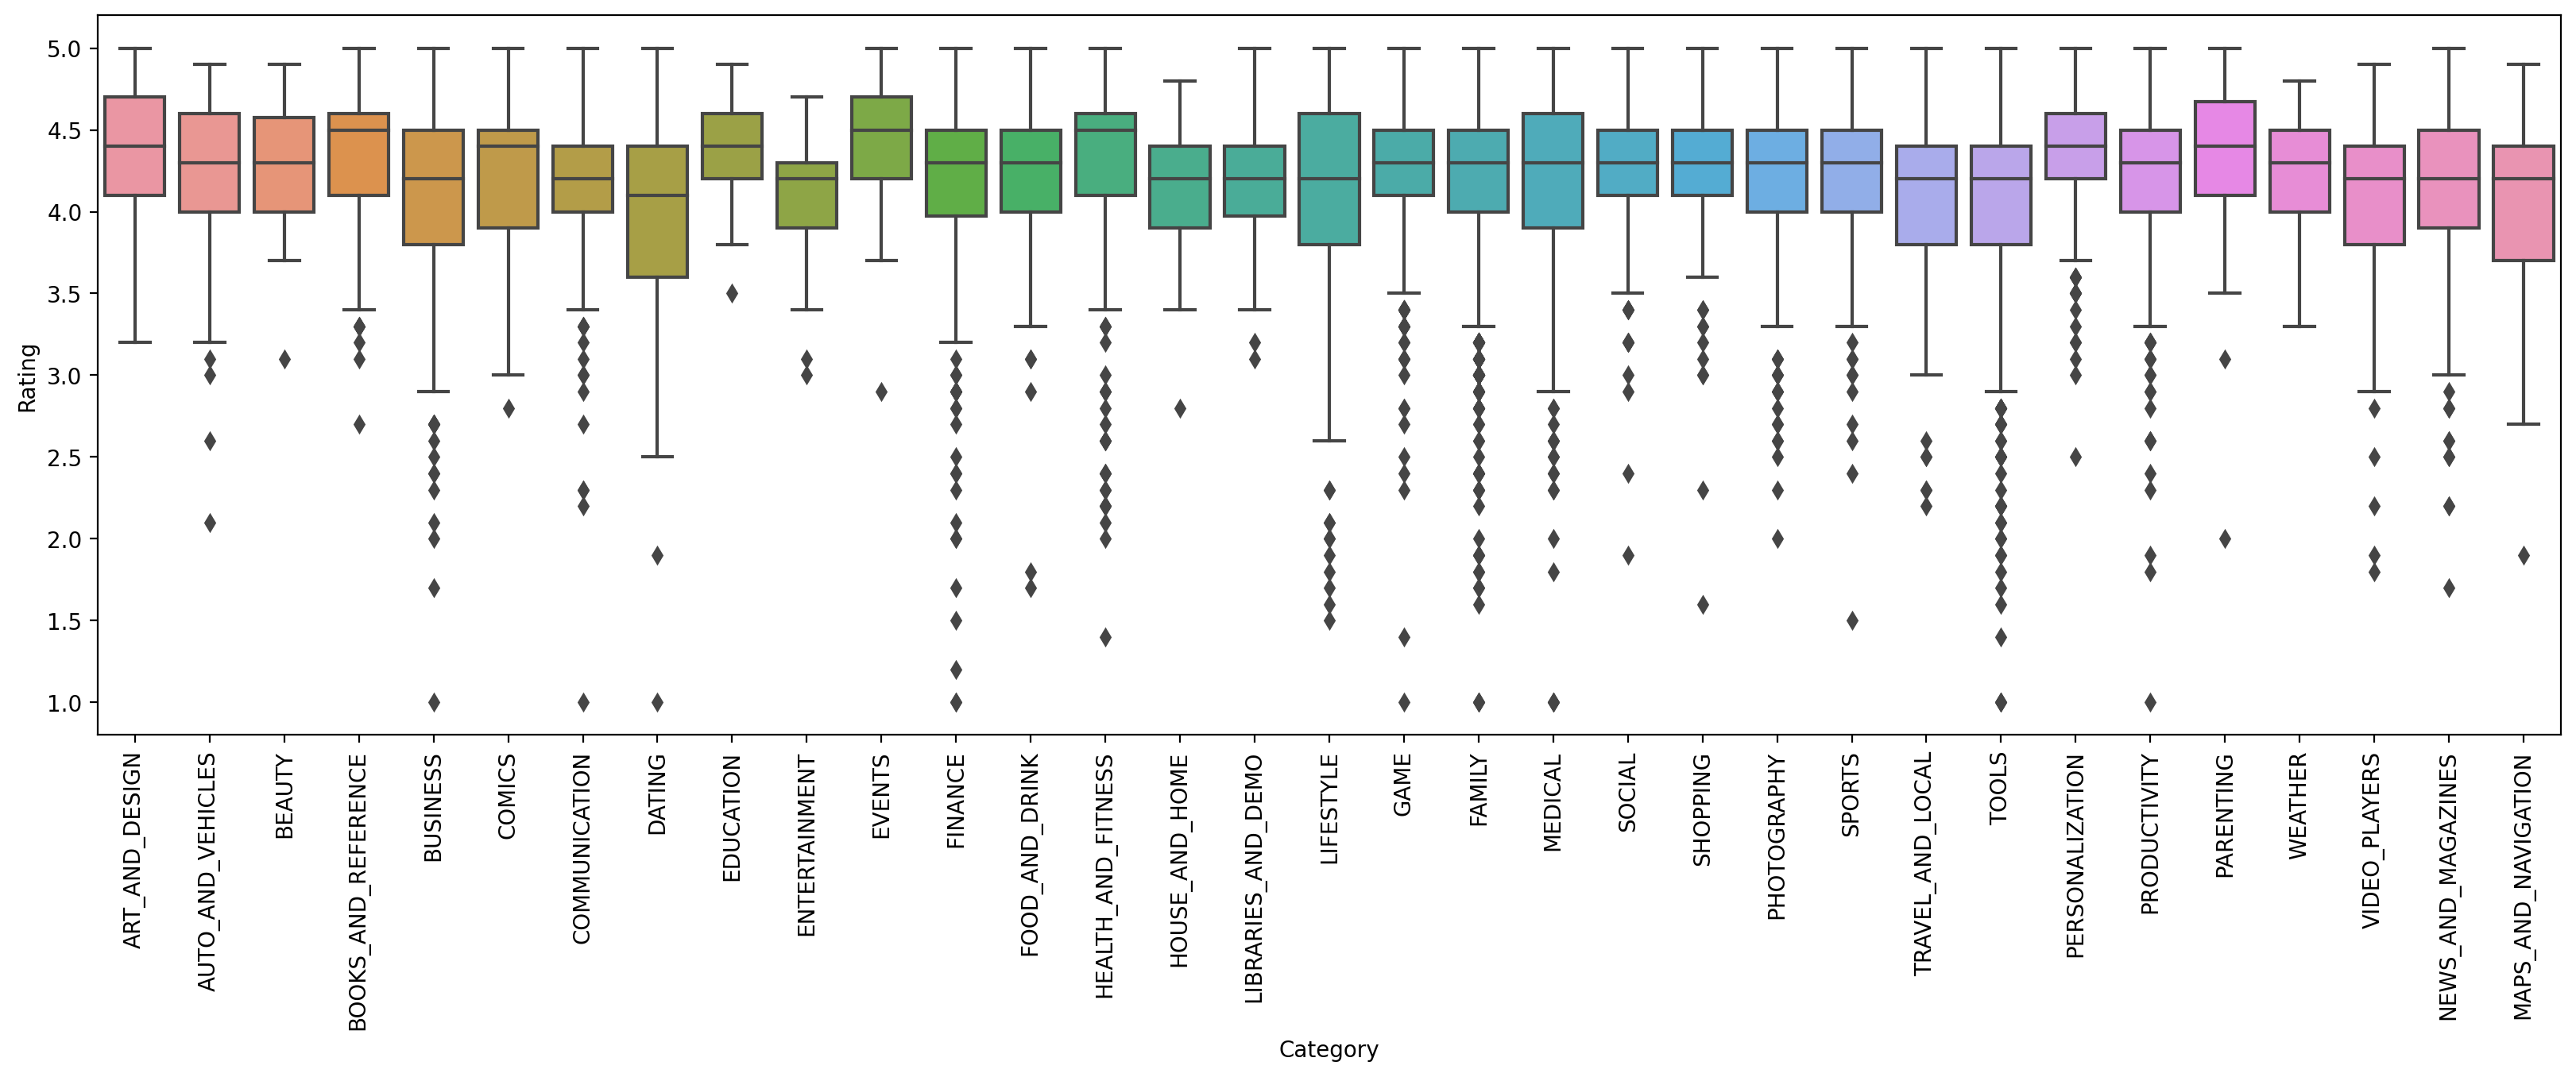

In [70]:
plt.figure(figsize=(20,6), dpi=200)
sns.boxplot(x="Category", y="Rating", data=data_apps)
plt.xticks(rotation=90);

In [71]:
# Let's sort by Category best scored on average.
data_apps.groupby(["Category"]).agg({"Rating": {"mean", "min", "max"}}).sort_values(by=("Rating", "mean"), ascending=False)

Rating               
                       max      mean  min
Category                                 
EVENTS                 5.0  4.435556  2.9
ART_AND_DESIGN         5.0  4.359322  3.2
EDUCATION              4.9  4.352381  3.5
BOOKS_AND_REFERENCE    5.0  4.344970  2.7
PERSONALIZATION        5.0  4.332215  2.5
PARENTING              5.0  4.300000  2.0
BEAUTY                 4.9  4.278571  3.1
SOCIAL                 5.0  4.247291  1.9
GAME                   5.0  4.244432  1.0
WEATHER                4.8  4.243056  3.3
HEALTH_AND_FITNESS     5.0  4.243033  1.4
SHOPPING               5.0  4.230556  1.6
SPORTS                 5.0  4.218774  1.5
AUTO_AND_VEHICLES      4.9  4.190411  2.1
FAMILY                 5.0  4.184092  1.0
PRODUCTIVITY           5.0  4.183389  1.0
COMICS                 5.0  4.181481  2.8
LIBRARIES_AND_DEMO     5.0  4.178125  3.1
FOOD_AND_DRINK         5.0  4.171277  1.7
MEDICAL                5.0  4.165862  1.0
PHOTOGRAPHY            5.0  4.155894  2.0
HOUSE_AND_HOME         4.8  4.140984  2.8
ENTERTAINMENT          4.7  4.129885  3.0
NEWS_AND_MAGAZINES     5.0  4.121569  1.7
COMMUNICATION          5.0  4.121484  1.0
FINANCE                5.0  4.118581  1.0
LIFESTYLE              5.0  4.102027  1.5
BUSINESS               5.0  4.098479  1.0
TRAVEL_AND_LOCAL       5.0  4.069519  2.2
VIDEO_PLAYERS          4.9  4.044966  1.8
TOOLS                  5.0  4.040278  1.0
MAPS_AND_NAVIGATION    4.9  4.036441  1.9
DATING                 5.0  3.980451  1.0

Let's observe Relationship between Category and number of Reviews. Those categories with the highest number of reviews are SOCIAL, COMMUNICATION and GAME.

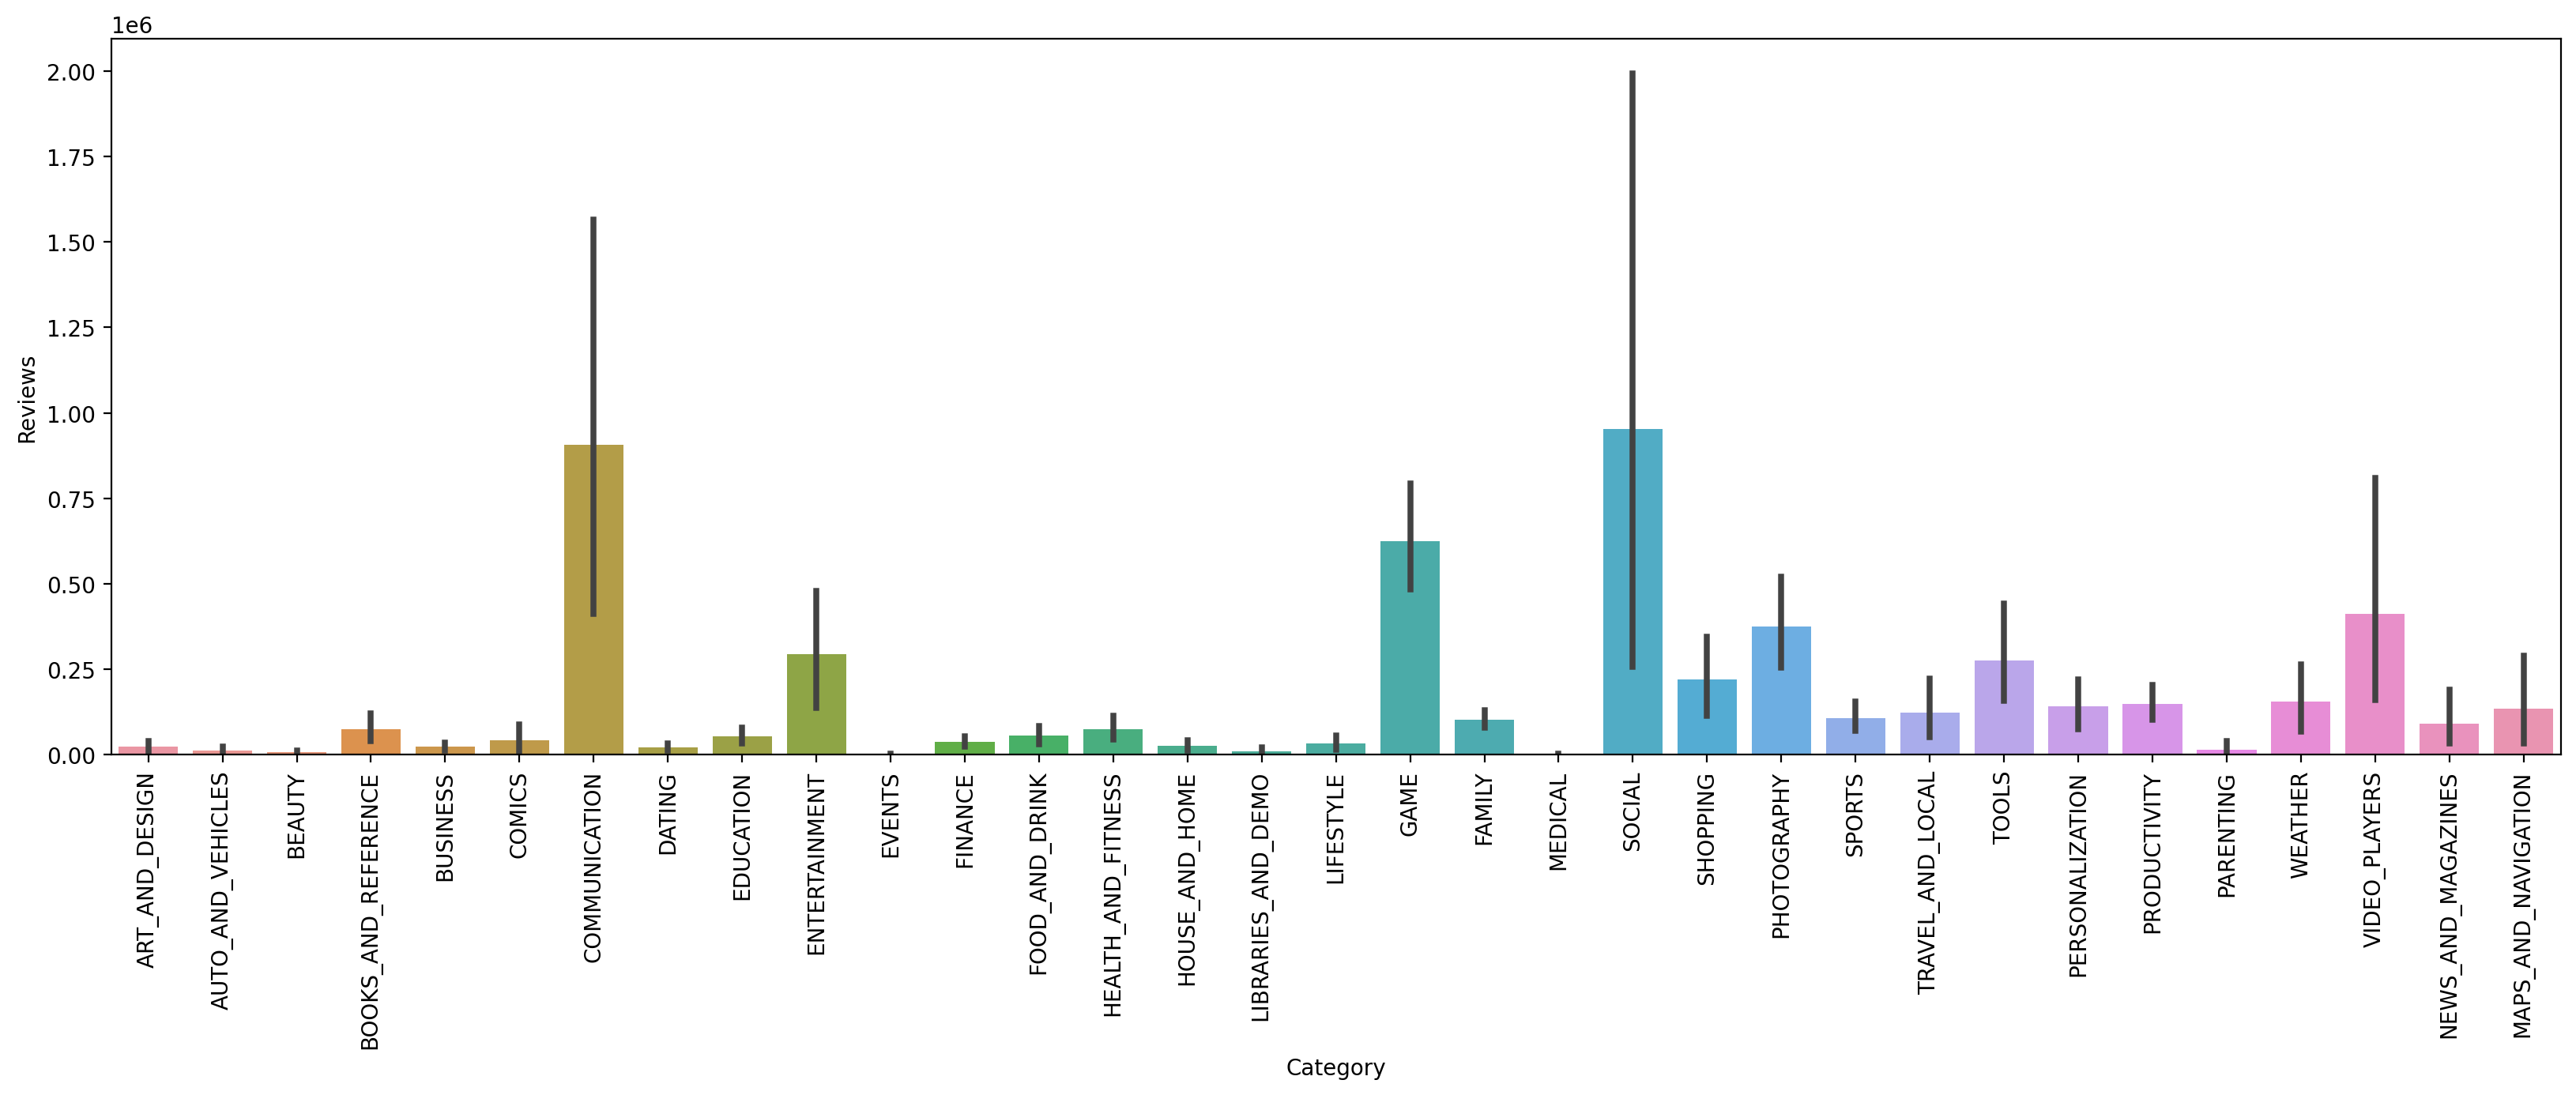

In [72]:
plt.figure(figsize=(20,6), dpi=200)
sns.barplot(x="Category", y="Reviews", data=data_apps)
plt.xticks(rotation=90);

Let's take a look at what happens with the genres of an application. Looking at the possible values of the genres, it seems that they generally share the same value as the category or specify some sub-genre within that category (such as "Puzzle" to define some type of game).

In "Genres" the genres are separated by ";", and some apps have two genres. We are going to save in other columns the "Main Genre" (the first) and the "Secondary Genre" (the second).

In [73]:
def get_main_genre(genres):
    genres = genres.split(";")
    return genres[0]
    
def get_secondary_genre(genres):
    genres = genres.split(";")
    second_g = ""
    if len(genres) > 1:
        return genres[1]
        
    return ""

data_apps["Main Genre"] = data_apps["Genres"].apply(get_main_genre)
data_apps["Secondary Genre"] = data_apps["Genres"].apply(get_secondary_genre)

We are going to evaluate the number of apps whose Category and Main Genre is the same. More than half of the time, the category coincides with the first assigned gender, so there is duplication of information. But let's see what happens to the ones that don't match.

In [74]:
def the_same(dataframe):
    category = dataframe["Category"].replace("_", " ").replace("AND",  "&").lower()
    main_genre = dataframe["Main Genre"].lower()
    
    return category == main_genre

data_apps["the_same"] = data_apps.apply(the_same, axis=1)
data_apps["the_same"].value_counts()

True     6662
False    2981
Name: the_same, dtype: int64

For apps whose Category and Main Genre do not match:

- In VIDEO_PLAYERS, the genre is Video Players & Editors.
- In GAME, genres are game subcategories/genres.
- In FAMILY, the genres are very varied.

In [75]:
group = data_apps[~data_apps["the_same"]].groupby(["Category", "Main Genre"])
group.size()

Category       Main Genre             
FAMILY         Action                      11
               Adventure                    7
               Arcade                      15
               Art & Design                 4
               Board                       18
               Books & Reference            3
               Card                         2
               Casual                     203
               Communication                1
               Education                  474
               Educational                102
               Entertainment              501
               Health & Fitness             2
               Lifestyle                    1
               Music                        3
               Music & Audio                1
               Puzzle                     118
               Racing                      17
               Role Playing               103
               Simulation                 197
               Sports                    

Let's see if the Main Genre can tell us anything about the ratings.

Although "Events" is the best punctuated on average (and this was already told us by Category), new information now appears, such as Word and Puzzle very well punctuated (within the "Game" Category).

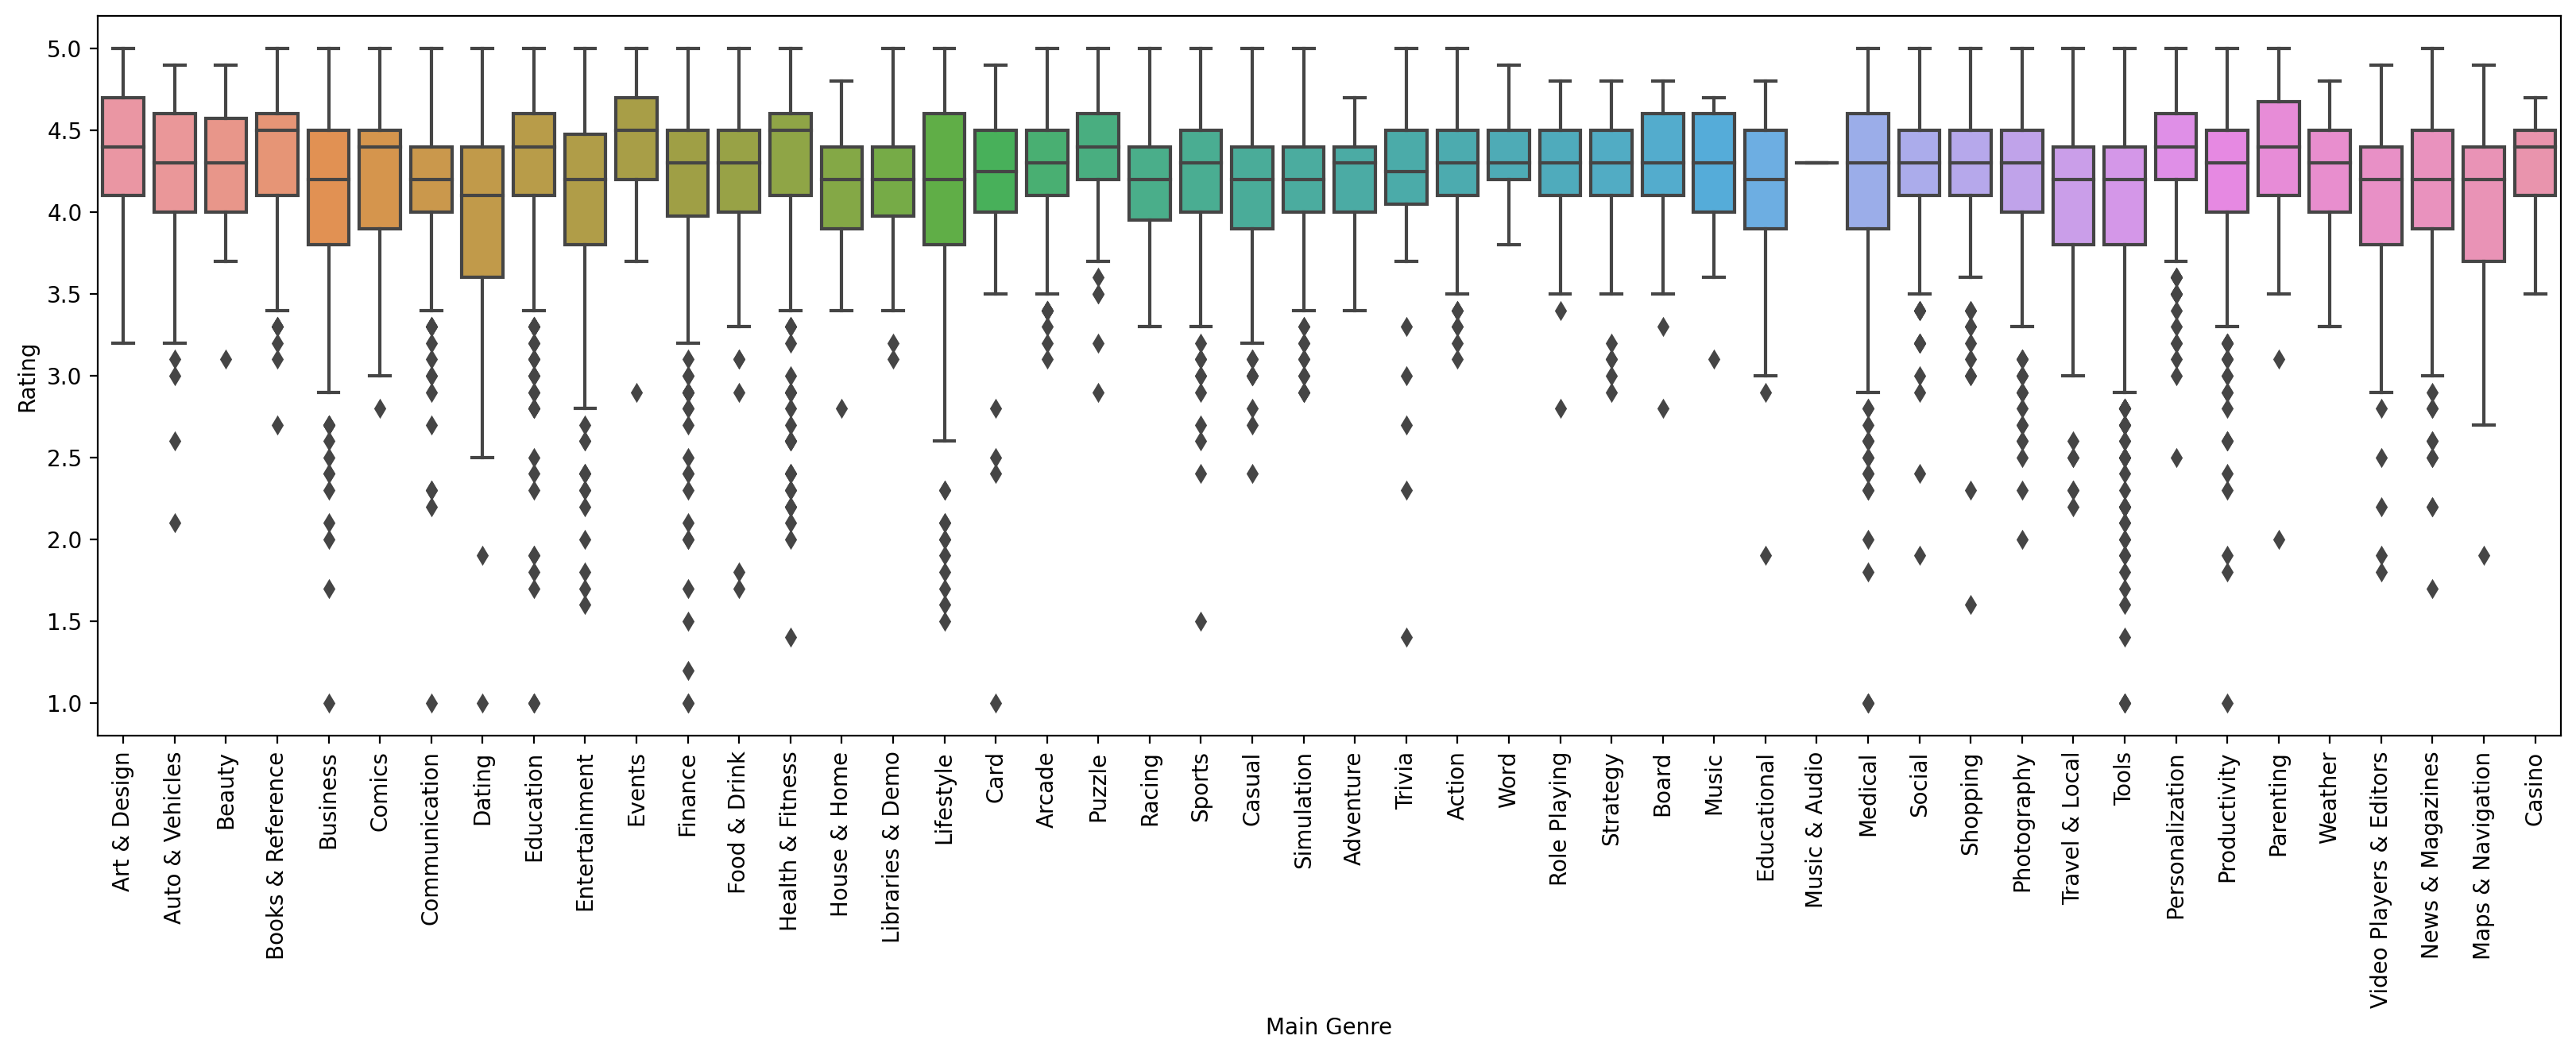

In [76]:
plt.figure(figsize=(20,6), dpi=200)
sns.boxplot(x="Main Genre", y="Rating", data=data_apps)
plt.xticks(rotation=90);

Let's see the relationship between the Main Genre and the number of Reviews. We can observe subgenres with many reviews such as Strategy, Arcade, Casual, among others.

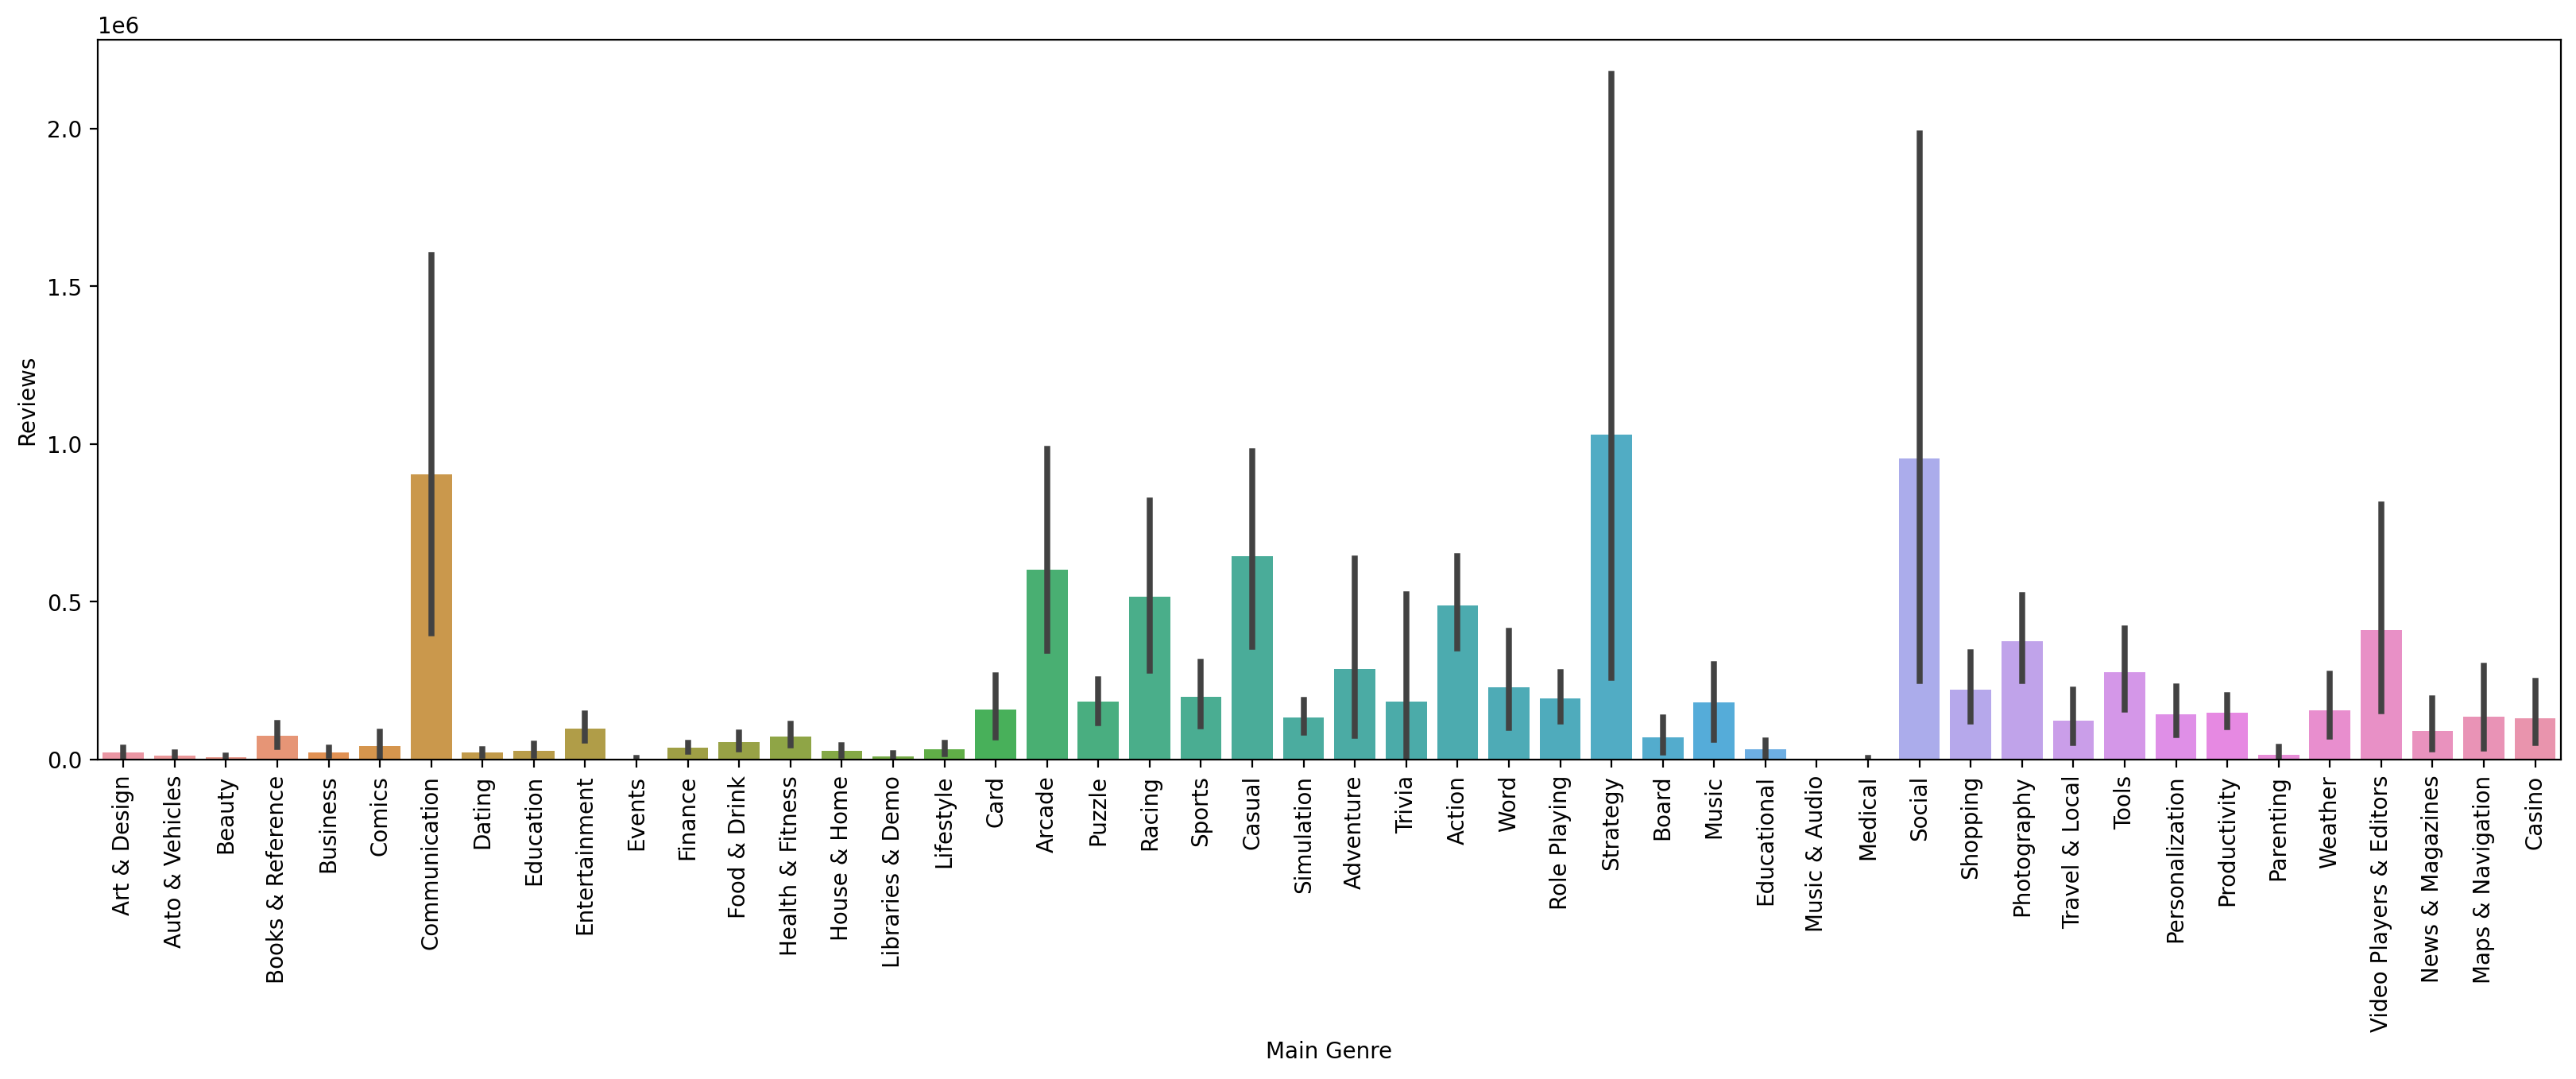

In [77]:
plt.figure(figsize=(20,6), dpi=200)
sns.barplot(x="Main Genre", y="Reviews", data=data_apps)
plt.xticks(rotation=90);

Regarding the Secondary Genre, since only a very small percentage of the data has a secondary genre, we will not use this category.

In [78]:
number_rows = 9643
print(f"Percentage of apps without Secondary Genre: {round((len(data_apps[data_apps['Secondary Genre'] == '']) / number_rows) * 100, 2)}%") 
print(f"Percentage of apps with Secondary Genre: {round((len(data_apps[data_apps['Secondary Genre'] != '']) / number_rows) * 100, 2)}%") 

#data_apps.groupby(["Secondary Genre"]).agg({"Rating": {"mean", "min", "max", "std"}}).sort_values(by=("Rating", "mean"), ascending=False)

Percentage of apps without Secondary Genre: 95.93%
Percentage of apps with Secondary Genre: 4.07%


Now let's see the "Type" feature. Most of the apps are free. Paid apps tend to have a slightly better rating than free ones.

<AxesSubplot:xlabel='Type', ylabel='Rating'>

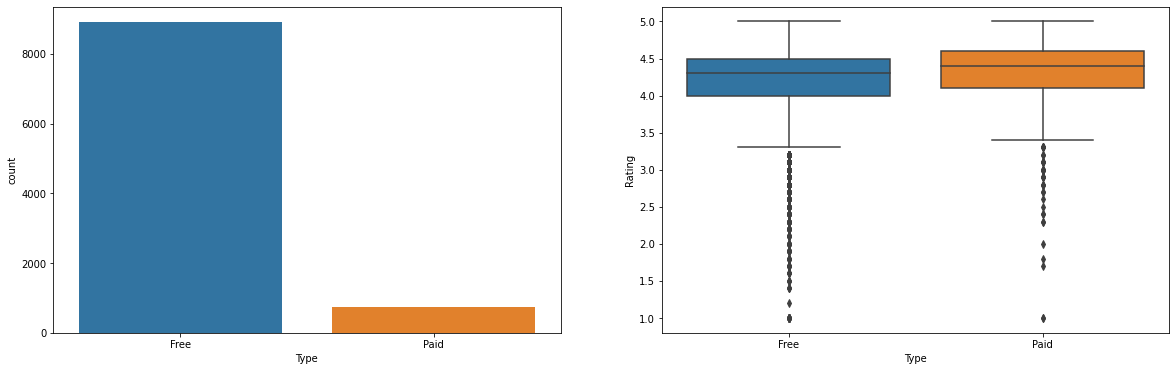

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6));
sns.countplot(data=data_apps, x="Type", ax=axes[0])
sns.boxplot(data=data_apps, x="Type", y="Rating", ax=axes[1])

Let's now see "Content Rating", and its relationship with "Rating". Depending on the Content Rating of the operation, some final ratings are better (such as Adults only 18+).

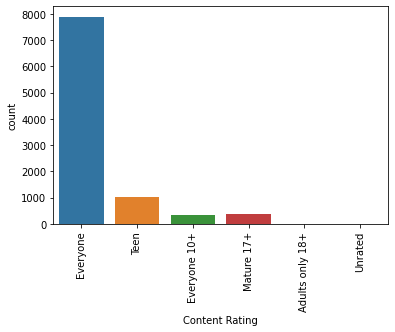

In [80]:
# data_apps["Content Rating"].value_counts()
sns.countplot(x=data_apps["Content Rating"])
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Content Rating', ylabel='Rating'>

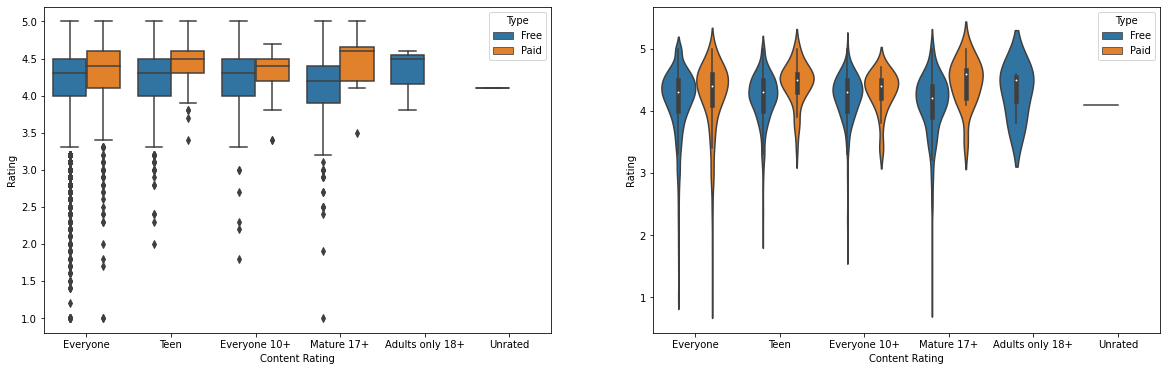

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6));
sns.boxplot(data=data_apps, x="Content Rating", y="Rating", hue="Type", ax=axes[0])
sns.violinplot(data=data_apps, x='Content Rating', y='Rating', hue="Type", ax=axes[1])

In [82]:
data_apps[data_apps["Content Rating"] == "Unrated"]
# data_apps[data_apps["Content Rating"] == "Adults only 18+"]

App Category  Rating  Reviews  Size  Installs  Type  \
7312     Best CG Photography   FAMILY     NaN        1   2.5       500  Free   
8266  DC Universe Online Map    TOOLS     4.1     1186   6.4     50000  Free   

      Price Content Rating         Genres Last Updated Current Ver  \
7312    0.0        Unrated  Entertainment   2015-06-24         5.2   
8266    0.0        Unrated          Tools   2012-02-27         1.3   

       Android Ver  Year Updated  Simplified App Ver  Simplified Android Ver  \
7312    3.0 and up          2015                 5.0                     3.0   
8266  2.3.3 and up          2012                 1.0                     2.0   

         Main Genre Secondary Genre  the_same  
7312  Entertainment                     False  
8266          Tools                      True

Let's change the outliers from "Unrated" to "Everyone" for these two cases.

In [83]:
data_apps.loc[data_apps["Content Rating"] == "Unrated", "Content Rating"] = "Everyone"

# Creation of the models <a name="modelcreation"></a>

Now let's start preparing the data for its use in the models. We are going to test how the following models behave:
- LinearRegression (basic)
- GradientBoostingRegressor (progressively improves, minimizing the loss function -MSE-)
- RandomForestRegressor (trains different decision trees on different parts of the dataset, and keeps the average).

In order to use the dataset that is already clean of missing values and outliers, we are first going to select the columns that we are actually going to use as features.

Then, we are going to separate the dataset into two: one where there are no missing values in Rating (variable to predict) and another where there are, in order to use KNNImputer.

Next, we are going to standardize the numerical features, and encode (OneHotEncoder) the categorical ones.

We are going to train the models for these two datasets, and then evaluate their performance, focusing primarily on the models trained on the dataset that has no imputed values for Rating.

## Dropping columns <a name="dropcolumns"></a>

We are going to remove the columns that we are not going to use. Some of these could be useful for other types of models such as neural networks, but we are not going to try those models now.

In [84]:
columns_to_remove = ["App", "Price", "Genres", "Last Updated", "Current Ver", "Android Ver", "Simplified App Ver", 
                     "Secondary Genre", "the_same"]

data_apps = data_apps.drop(columns_to_remove, axis=1)
data_apps

Category  Rating  Reviews  Size  Installs  Type  \
0           ART_AND_DESIGN     4.1      159  19.0     10000  Free   
2           ART_AND_DESIGN     4.7    87510   8.7   5000000  Free   
3           ART_AND_DESIGN     4.5   215644  25.0  50000000  Free   
4           ART_AND_DESIGN     4.3      967   2.8    100000  Free   
5           ART_AND_DESIGN     4.4      167   5.6     50000  Free   
...                    ...     ...      ...   ...       ...   ...   
10837               FAMILY     5.0        4   3.6       100  Free   
10838              MEDICAL     NaN        3   9.5      1000  Free   
10839  BOOKS_AND_REFERENCE     4.5      114  20.4      1000  Free   
10840            LIFESTYLE     4.5   398307  19.0  10000000  Free   
10841               SPORTS     4.9     1230  14.0    500000  Free   

      Content Rating  Year Updated  Simplified Android Ver         Main Genre  
0           Everyone          2018                     4.0       Art & Design  
2           Everyone          2018                     4.0       Art & Design  
3               Teen          2018                     4.0       Art & Design  
4           Everyone          2018                     4.0       Art & Design  
5           Everyone          2017                     2.0       Art & Design  
...              ...           ...                     ...                ...  
10837       Everyone          2018                     4.0          Education  
10838       Everyone          2017                     2.0            Medical  
10839     Mature 17+          2015                     3.0  Books & Reference  
10840       Everyone          2018                     4.0          Lifestyle  
10841       Everyone          2018                     4.0             Sports  

[9643 rows x 10 columns]

## Separating datasets <a name="datasets"></a>

We are going to have two datasets: data_apps_without_nan and data_apps_rating_imputer.

For data_apps_rating_imputer we are going to use KNNImputer to fill in the missing values in Rating.

In [85]:
data_apps_rating_without_nan = data_apps[~data_apps["Rating"].isna()].copy()
data_apps_rating_imputer = data_apps.copy()

## Preprocessing <a name="preprocess"></a>

We are going to have a preprocessing stage that uses a MinMaxScaler for numeric values and creates variable dummies (one-hot encoding) for categorical variables.

In [86]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

numeric_features = ["Reviews", "Size", "Installs"] #, "Year Updated", "Simplified Android Ver"]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

ordinal_features = ["Year Updated", "Simplified Android Ver"]
ordinal_transformer = OrdinalEncoder()

# We need to create dummy variables for this columns
def add_dummy_variables(data):
    categorical_features = ["Category", "Type", "Content Rating", "Main Genre"]
    dummies = pd.get_dummies(data[categorical_features], drop_first=True)
    data = data.drop(categorical_features, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

## Using KNNImputer

We are going to use KNNImputer on the data_apps_rating_imputer dataset to fill in the missing values in Rating.

In [87]:
from sklearn.impute import KNNImputer

# Our features are data_apps_rating_imputer
imputer_X = data_apps_rating_imputer.copy()

# Categorical variables
imputer_X = add_dummy_variables(imputer_X)

# Standarization of numeric variables
imputer_X[numeric_features] = numeric_transformer.fit_transform(imputer_X[numeric_features])
imputer_X[ordinal_features] = ordinal_transformer.fit_transform(imputer_X[ordinal_features])

# Creation of the model
imputer = KNNImputer(n_neighbors=50)

# Impute missing values
df_imputer = pd.DataFrame(imputer.fit_transform(imputer_X),columns = imputer_X.columns)

# We add them to our dataset
data_apps_rating_imputer["Rating"] = np.round(df_imputer["Rating"].values, 1)

### Functions we are going to use

We list here  series of functions that we are going to use: 
- to separate in X and y; 
- to perform a fit_transform on the training data, 
and a transform on the test data; fit a model with the training data and obtain predictions about the test data; calculate MAE, MSE and RMSE; and plot the predicted values.

In [88]:
# Split the dataset in X (features) and y (variable to predict)
def get_X_and_y(dataset):
    X = dataset.drop(["Rating"], axis=1)
    y = dataset["Rating"]
    return X, y

# Fit-transform of X_train 
def fit_transform(X):
    X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])
    X[ordinal_features] = ordinal_transformer.fit_transform(X[ordinal_features])
    return X

# Transform of X_test
def transform(X):
    X[numeric_features] = numeric_transformer.transform(X[numeric_features])
    X[ordinal_features] = ordinal_transformer.transform(X[ordinal_features])
    return X

In [89]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit of X_train, y_train, return the predictions for X_test
def fit_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

# Evaluate the model with y_test (expected values) and y_pred (predicted values)
def evaluate(y_test, y_pred, model_name):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)

    print(f"{model_name} MAE: {MAE}\n{model_name} MSE: {MSE}\n{model_name} RMSE: {RMSE}\n")
    
def plotting_models_performance(list_models, y_test):

    fig, axes = plt.subplots(1,3, figsize=(20, 6))
    i = 0
    
    for model_name, model_pred in list_models:
        sns.scatterplot(x=model_pred, y=y_test, ax=axes[i])
        sns.scatterplot(x=y_test, y=y_test, ax=axes[i])
        axes[i].set_title(model_name);

        i += 1

## Testing the models for data_apps_rating_without_nan

We are going to train the model on the data_apps_rating_without_nan data, and then evaluate the results.

In [90]:
# Creation of the models
linear_model = LinearRegression()
gradient_boosting_model = GradientBoostingRegressor(n_estimators=500, random_state=52)
random_forest_model = RandomForestRegressor(n_estimators=500, random_state=52)

# Get dataset
without_nan_X, without_nan_y = get_X_and_y(data_apps_rating_without_nan)

# One hot encoding
without_nan_X = add_dummy_variables(without_nan_X)

# Getting train and test sets
X_train, X_test, y_train, y_test = train_test_split(without_nan_X, without_nan_y, test_size=0.33, random_state=52)

# Transform of the data (scaled_X_train y scaled_X_test)
X_train = fit_transform(X_train)
X_test = transform(X_test)

Now let's fit the models with the training data and evaluate them with the test data.

In [91]:
# Fit and predict for each model

linear_pred = fit_predict(linear_model, X_train, y_train, X_test)
gradient_boosting_pred = fit_predict(gradient_boosting_model, X_train, y_train, X_test)
random_forest_pred = fit_predict(random_forest_model, X_train, y_train, X_test)

## Comparing models <a name="compareresults"></a>

Now we are going to compare the results of the three models using the MAE and RMSE metrics.

In [92]:
# Evaluation of the model
models_predictions = [
    ("Linear Regression", linear_pred),
    ("Gradient Boosting Regressor", gradient_boosting_pred),
    ("Random Forest Regressor", random_forest_pred)
]

for model_name, model_pred in models_predictions:
    evaluate(y_test, model_pred, model_name)

Linear Regression MAE: 0.3688857042987611
Linear Regression MSE: 0.2789145393326183
Linear Regression RMSE: 0.5281236023248898

Gradient Boosting Regressor MAE: 0.3425347361145641
Gradient Boosting Regressor MSE: 0.2564845479333203
Gradient Boosting Regressor RMSE: 0.506443035230341

Random Forest Regressor MAE: 0.3463969355265244
Random Forest Regressor MSE: 0.26610786205042675
Random Forest Regressor RMSE: 0.5158564355035485



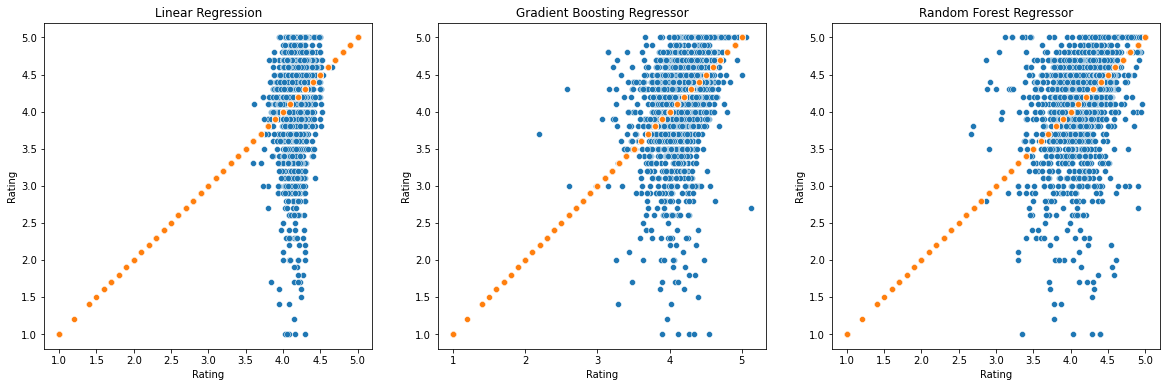

In [93]:
plotting_models_performance(models_predictions, y_test)

The model with the best performance is Gradient Boosting Regressor, with 0.3425 mean absolute error and 0.5064 root-mean-square error. These values represent on average how far it is from the expected value (0.34... points); and we have a slightly higher value in RMSE since it is penalizing those predictions that are far from the real value (for example, those that predict a rating of 4 to applications that have 1).

The graphs help us to understand a little how the model behaves. In general, they all tend to predict scores around 4 (which is one of the most common ratings in our dataset). We can see that it is hard to predict lower ratings, and there is still a lot of improvement to be made. Perhaps as a first model it is adequate, but we could still tune the parameters and perhaps try different features or more complex models, such as neural networks.

## Testing the data_apps_rating_imputer dataset

Let's do the same process, but this time with the dataset that has imputed data for the Rating missing values.

In [94]:
# Creation of the models
linear_model = LinearRegression()
gradient_boosting_model = GradientBoostingRegressor(n_estimators=500, random_state=52)
random_forest_model = RandomForestRegressor(n_estimators=500, random_state=52)

# Getting the dataset
imputer_X, imputer_y = get_X_and_y(data_apps_rating_imputer)

# One hot encoding
imputer_X = add_dummy_variables(imputer_X)

# Split in train and test set
X_train, X_test, y_train, y_test = train_test_split(imputer_X, imputer_y, test_size=0.33, random_state=52)

# Fit transform of training data, and transform of test data (scaled_X_train, scaled_X_test)
X_train = fit_transform(X_train)
X_test = transform(X_test)

In [95]:
# Fit and predict for each model
linear_pred = fit_predict(linear_model, X_train, y_train, X_test)
gradient_boosting_pred = fit_predict(gradient_boosting_model, X_train, y_train, X_test)
random_forest_pred = fit_predict(random_forest_model, X_train, y_train, X_test)

In [96]:
# Evaluation of the models
models_predictions = [
    ("Linear Regression", linear_pred),
    ("Gradient Boosting Regressor", gradient_boosting_pred),
    ("Random Forest Regressor", random_forest_pred)
]

for model_name, model_pred in models_predictions:
    evaluate(y_test, model_pred, model_name)

Linear Regression MAE: 0.32250161368659575
Linear Regression MSE: 0.22278663838922944
Linear Regression RMSE: 0.4720027948955699

Gradient Boosting Regressor MAE: 0.3070471410950793
Gradient Boosting Regressor MSE: 0.2084351702062645
Gradient Boosting Regressor RMSE: 0.4565470076632466

Random Forest Regressor MAE: 0.3217256991086809
Random Forest Regressor MSE: 0.22527716040105364
Random Forest Regressor RMSE: 0.4746337118252913



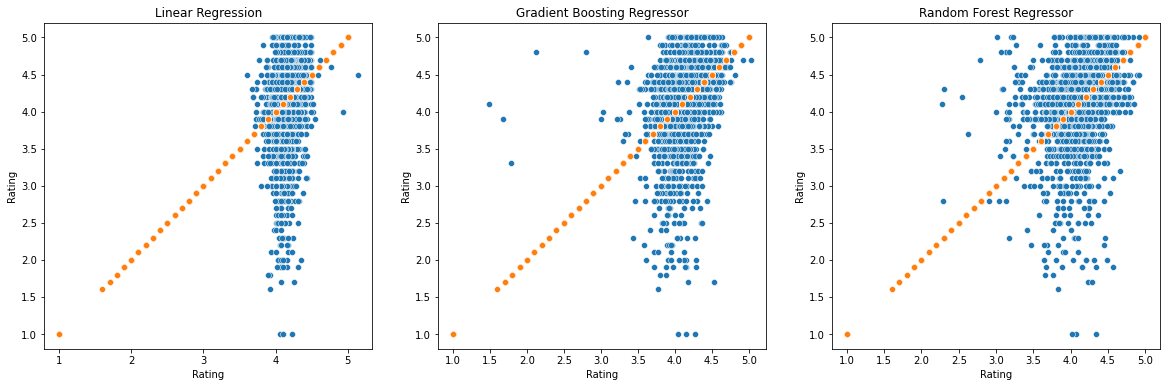

In [97]:
plotting_models_performance(models_predictions, y_test)

In this case, Gradient Boosting Regressor also performs better than the rest. The metrics improve a bit (0.3070 for MAE and 0.4565 for RMSE). Perhaps this helps us decide on Gradient Boosting Regressor as the model of choice. In any case, we must not forget that this model is trained on a dataset with imputed data in the dependent variable, which can add a bit of noise in the sense that we are not using "real" values but calculated ones.

I would use the results of this to consider another model (think parameter tuning, for example) if the results look very favorable for another of the options.

## Things that were not done

There is another series of tasks that for reasons of time I could not address, but I leave them here because I considered them at some point.

Other things that could have been done:
- tuning of the parameters of the models (or the chosen model) using GridSearchCV.
- use the reviews dataset (specifically review polarity) to enrich the model; or to try to complete those missing data in Rating.
- Evaluate how different types of preprocessing affect the data (MinMaxScaler or StandardScaler, OrdinalEncoder, OneHotEncoding).
- try to create new features (example: does the length of the app name affect the number of installations or reviews, and eventually the rating?).
- test how much the model changes (and how it behaves) if the outliers of the big applications like Facebook, Instagram, Google are removed.
- test a neural network.